# mRNA Classification for 2-6 with all list and 6-12 with FDR<0.05

In [40]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


In [44]:
path1 = Path("/Users/zainabnazari/mfuzz/data")
path2 = Path("/Users/zainabnazari/mfuzz/main")
path3 = Path("/Users/zainabnazari/mfuzz/result")

In [48]:
data_m = pd.read_excel(path1/"merged_mixed_mRNA.xlsx")
data_m['t0'] = 0.0
data_m

ID     baseMean    FC_2_6   FC_6_12   t0
0    ENSMUSG00000000120   116.392155 -0.182776 -1.046293  0.0
1    ENSMUSG00000000127  1153.740468 -0.077744  0.182205  0.0
2    ENSMUSG00000000194  1437.365519  0.015781 -0.123912  0.0
3    ENSMUSG00000000215    22.585220 -0.817323 -1.267013  0.0
4    ENSMUSG00000000253   249.705093  0.052584 -0.283247  0.0
..                  ...          ...       ...       ...  ...
732  ENSMUSG00000136702   121.044694  0.337610  0.542064  0.0
733  ENSMUSG00000139001    43.133424 -1.233945 -1.562018  0.0
734  ENSMUSG00000141743    13.929759  0.204093  1.385601  0.0
735  ENSMUSG00000141955   185.595693 -1.174173 -1.153382  0.0
736  ENSMUSG00000142531    13.369055 -0.330767  2.342963  0.0

[737 rows x 5 columns]

# Adding the Fold Change Values

In [49]:
# Define log2(expression) values relative to 2M
data_m['t1'] = data_m['t0'] + data_m['FC_2_6']
data_m['t2'] = data_m['t1'] + data_m['FC_6_12']

In [50]:
data_m[data_m['ID']=='ENSMUSG00000000127']

ID     baseMean    FC_2_6   FC_6_12   t0        t1  \
1  ENSMUSG00000000127  1153.740468 -0.077744  0.182205  0.0 -0.077744   

         t2  
1  0.104461

# Evaluating the max values

In [51]:
abs(data_m['t1']).max()

2.37155158936253

In [52]:
abs(data_m['t2']).max()

3.19139396376646

# Classifications and plotting

In [53]:

# plotting
sns.set(style='whitegrid', context='talk', palette='Set2')
rcParams['font.family'] = 'serif'
rcParams['figure.dpi'] = 300

# Define color palette
palette = sns.color_palette("husl", n_colors=10)  # Good distinct hues

# compute angle between time points (in degrees)
def compute_angle(delta_expr, delta_time=3.19):
    slope = delta_expr / delta_time
    angle = np.degrees(np.arctan(slope))
    return angle

# Classification function with angles
def classify_pattern(row, angle_thresh=3, steady_thresh=2.99):
    delta1 = row['t1'] - row['t0']
    delta2 = row['t2'] - row['t1']
    
    angle1 = compute_angle(delta1)
    angle2 = compute_angle(delta2)

    if abs(angle1) < steady_thresh and angle2 > angle_thresh:
        return 'Steady-then-Increase'
    elif abs(angle1) < steady_thresh and angle2 < -angle_thresh:
        return 'Steady-then-Decrease'
    elif angle1 > angle_thresh and angle2 < -angle_thresh:
        return 'Increase-then-Decrease'
    elif angle1 < -angle_thresh and angle2 > angle_thresh:
        return 'Decrease-then-Increase'
    elif angle1 > steady_thresh and angle2 > steady_thresh:
        return 'Gradual-Increase'
    elif angle1 < -steady_thresh and angle2 < -steady_thresh:
        return 'Gradual-Decrease'
    else:
        return 'Unclassified'

# Apply classification
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Plot grouped by pattern
timepoints = ['t0', 't1', 't2']
unique_patterns = data_m['pattern'].unique()

top_n = 5  # You can change this number


# Compute a "total change" metric
#data_m['total_change'] = (data_m['t1'] - data_m['t2']).abs()

# Custom total change computation based on pattern
def compute_total_change(row):
    pattern = row['pattern']
    fc_2_6 = row['FC_2_6']
    fc_6_12 = row['FC_6_12']

    if pattern in ['Gradual-Increase', 'Gradual-Decrease']:
        return abs(fc_2_6) + abs(fc_6_12)
    elif pattern in ['Steady-then-Increase', 'Steady-then-Decrease']:
        return abs(fc_6_12)
    elif pattern in ['Increase-then-Decrease', 'Decrease-then-Increase']:
        return abs(fc_6_12 - fc_2_6)
    else:
        return 0  # or np.nan if you'd prefer to ignore unclassified

# Apply classification first
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Then compute total change
data_m['total_change'] = data_m.apply(compute_total_change, axis=1)


# Apply classification
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Plot grouped by pattern
timepoints = ['t0', 't1', 't2']
unique_patterns = data_m['pattern'].unique();


# Optional: re-define your color palette once
palette = sns.color_palette("husl", n_colors=10)

def plot_mirna_pattern(pattern, top_n=5, data=data_m):
    """
    Plot mRNA expression for a given pattern type.

    Args:
        pattern (str): One of the classified patterns (e.g. 'Gradual-Increase')
        top_n (int): Number of top miRNAs to show by total expression change
        data (pd.DataFrame): DataFrame that includes columns t0, t1, t2, mRNA_ID, pattern, total_change
    """
    subset = data[data['pattern'] == pattern]
    if subset.empty:
        print(f"No data found for pattern: {pattern}")
        return

    top_subset = subset.nlargest(top_n, 'total_change')
    timepoints = ['t0', 't1', 't2']

    plt.figure(figsize=(8, 5))
    for i, (_, row) in enumerate(top_subset.iterrows()):
        color = palette[i % len(palette)]
        plt.plot(timepoints, row[timepoints], marker='o', linewidth=1.5, alpha=0.5, color=color)
        plt.text(timepoints[-1], row[timepoints[-1]], row['ID'], fontsize=8, color=color,
                 verticalalignment='center', horizontalalignment='left')

    plt.title(f'Pattern: {pattern} (Top {top_n})', fontsize=16)
    plt.xlabel('Time Point', fontsize=14)
    plt.ylabel('Expression Level (log2 FC)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()


# Saving the result in excel files

In [54]:
columns_to_save = ['ID', 'baseMean', 'FC_2_6', 'FC_6_12']

# Apply pattern classification to each row
data_m['pattern'] = data_m.apply(classify_pattern, axis=1)

# Add 'pattern' to the columns to be saved
columns_to_export = columns_to_save + ['pattern']

# Dictionary to store DataFrames by pattern
pattern_groups = {}

# Save each group to a separate Excel file
for pattern in data_m['pattern'].unique():
    group_data = data_m[data_m['pattern'] == pattern][columns_to_export]
    pattern_groups[pattern] = group_data

    # Make filename safe: replace spaces and special characters
    safe_pattern = pattern.replace(' ', '_').replace('/', '_')
    filename = f"Mixed_mRNA_{safe_pattern}.xlsx"
    
    # Save to Excel
    group_data.to_excel(path3 / filename, index=False)


# Whole table

In [55]:
data_m

ID     baseMean    FC_2_6   FC_6_12   t0        t1  \
0    ENSMUSG00000000120   116.392155 -0.182776 -1.046293  0.0 -0.182776   
1    ENSMUSG00000000127  1153.740468 -0.077744  0.182205  0.0 -0.077744   
2    ENSMUSG00000000194  1437.365519  0.015781 -0.123912  0.0  0.015781   
3    ENSMUSG00000000215    22.585220 -0.817323 -1.267013  0.0 -0.817323   
4    ENSMUSG00000000253   249.705093  0.052584 -0.283247  0.0  0.052584   
..                  ...          ...       ...       ...  ...       ...   
732  ENSMUSG00000136702   121.044694  0.337610  0.542064  0.0  0.337610   
733  ENSMUSG00000139001    43.133424 -1.233945 -1.562018  0.0 -1.233945   
734  ENSMUSG00000141743    13.929759  0.204093  1.385601  0.0  0.204093   
735  ENSMUSG00000141955   185.595693 -1.174173 -1.153382  0.0 -1.174173   
736  ENSMUSG00000142531    13.369055 -0.330767  2.342963  0.0 -0.330767   

           t2                 pattern  total_change  
0   -1.229068        Gradual-Decrease      1.229068  
1    0.104461    Steady-then-Increase      0.182205  
2   -0.108132            Unclassified      0.000000  
3   -2.084336        Gradual-Decrease      2.084336  
4   -0.230663    Steady-then-Decrease      0.283247  
..        ...                     ...           ...  
732  0.879674        Gradual-Increase      0.879674  
733 -2.795963        Gradual-Decrease      2.795963  
734  1.589694        Gradual-Increase      1.589694  
735 -2.327555        Gradual-Decrease      2.327555  
736  2.012196  Decrease-then-Increase      2.673730  

[737 rows x 9 columns]

# Steady-then-Increase

In [56]:
data_r8 = pd.read_excel(path3/"Mixed_mRNA_Steady-then-Increase.xlsx")
data_r8.sort_values(by='FC_6_12', ascending=False, inplace=True)
data_r8.reset_index(drop=True)

ID      baseMean    FC_2_6   FC_6_12               pattern
0   ENSMUSG00000022123     96.027730 -0.084685  0.927957  Steady-then-Increase
1   ENSMUSG00000079293     25.283359 -0.045169  0.809490  Steady-then-Increase
2   ENSMUSG00000085837     24.000092 -0.036394  0.775277  Steady-then-Increase
3   ENSMUSG00000110618     56.212889  0.057964  0.726288  Steady-then-Increase
4   ENSMUSG00000103358    158.233563  0.091704  0.611842  Steady-then-Increase
5   ENSMUSG00000078877    212.876842 -0.132730  0.605948  Steady-then-Increase
6   ENSMUSG00000113679     53.728414  0.101109  0.570254  Steady-then-Increase
7   ENSMUSG00000018819     88.413412  0.146442  0.568984  Steady-then-Increase
8   ENSMUSG00000029821     71.037063  0.066036  0.562669  Steady-then-Increase
9   ENSMUSG00000100147    182.695613  0.061764  0.520936  Steady-then-Increase
10  ENSMUSG00000102600     80.360808  0.105684  0.504040  Steady-then-Increase
11  ENSMUSG00000051506    239.018422  0.043741  0.458236  Steady-then-Increase
12  ENSMUSG00000104950    143.598708 -0.091978  0.443318  Steady-then-Increase
13  ENSMUSG00000046191    134.029509 -0.122713  0.426550  Steady-then-Increase
14  ENSMUSG00000029334    519.972984  0.062065  0.426435  Steady-then-Increase
15  ENSMUSG00000004151   1368.399168  0.165639  0.358616  Steady-then-Increase
16  ENSMUSG00000047910    228.059483 -0.036078  0.356781  Steady-then-Increase
17  ENSMUSG00000087385    208.050391  0.058759  0.347065  Steady-then-Increase
18  ENSMUSG00000059173   1130.603853  0.161841  0.328883  Steady-then-Increase
19  ENSMUSG00000052676    227.542314 -0.107549  0.325093  Steady-then-Increase
20  ENSMUSG00000026872   4810.236724  0.128265  0.320714  Steady-then-Increase
21  ENSMUSG00000057181   1009.149414  0.088198  0.319074  Steady-then-Increase
22  ENSMUSG00000026275   1617.712837  0.147426  0.299294  Steady-then-Increase
23  ENSMUSG00000085438  10200.748102  0.119357  0.294056  Steady-then-Increase
24  ENSMUSG00000040209   4073.839180  0.027048  0.291134  Steady-then-Increase
25  ENSMUSG00000001542    430.632894  0.030554  0.287065  Steady-then-Increase
26  ENSMUSG00000001376   1038.309955 -0.018234  0.236149  Steady-then-Increase
27  ENSMUSG00000028914    665.937755  0.152097  0.235558  Steady-then-Increase
28  ENSMUSG00000055531   3193.701074 -0.089636  0.227089  Steady-then-Increase
29  ENSMUSG00000039478    654.014779  0.039881  0.225865  Steady-then-Increase
30  ENSMUSG00000069020    447.342901  0.094291  0.225528  Steady-then-Increase
31  ENSMUSG00000045103   4356.215890 -0.074464  0.209113  Steady-then-Increase
32  ENSMUSG00000046314    999.062275  0.108204  0.206875  Steady-then-Increase
33  ENSMUSG00000020580   3966.281839 -0.099072  0.205054  Steady-then-Increase
34  ENSMUSG00000024983   1268.734288  0.139763  0.189645  Steady-then-Increase
35  ENSMUSG00000000127   1153.740468 -0.077744  0.182205  Steady-then-Increase
36  ENSMUSG00000051285   4091.081300 -0.141359  0.178929  Steady-then-Increase
37  ENSMUSG00000069495   1062.798592 -0.051488  0.172797  Steady-then-Increase
38  ENSMUSG00000024238   4997.091123  0.100065  0.172652  Steady-then-Increase
39  ENSMUSG00000057335   2121.019572 -0.061220  0.170592  Steady-then-Increase

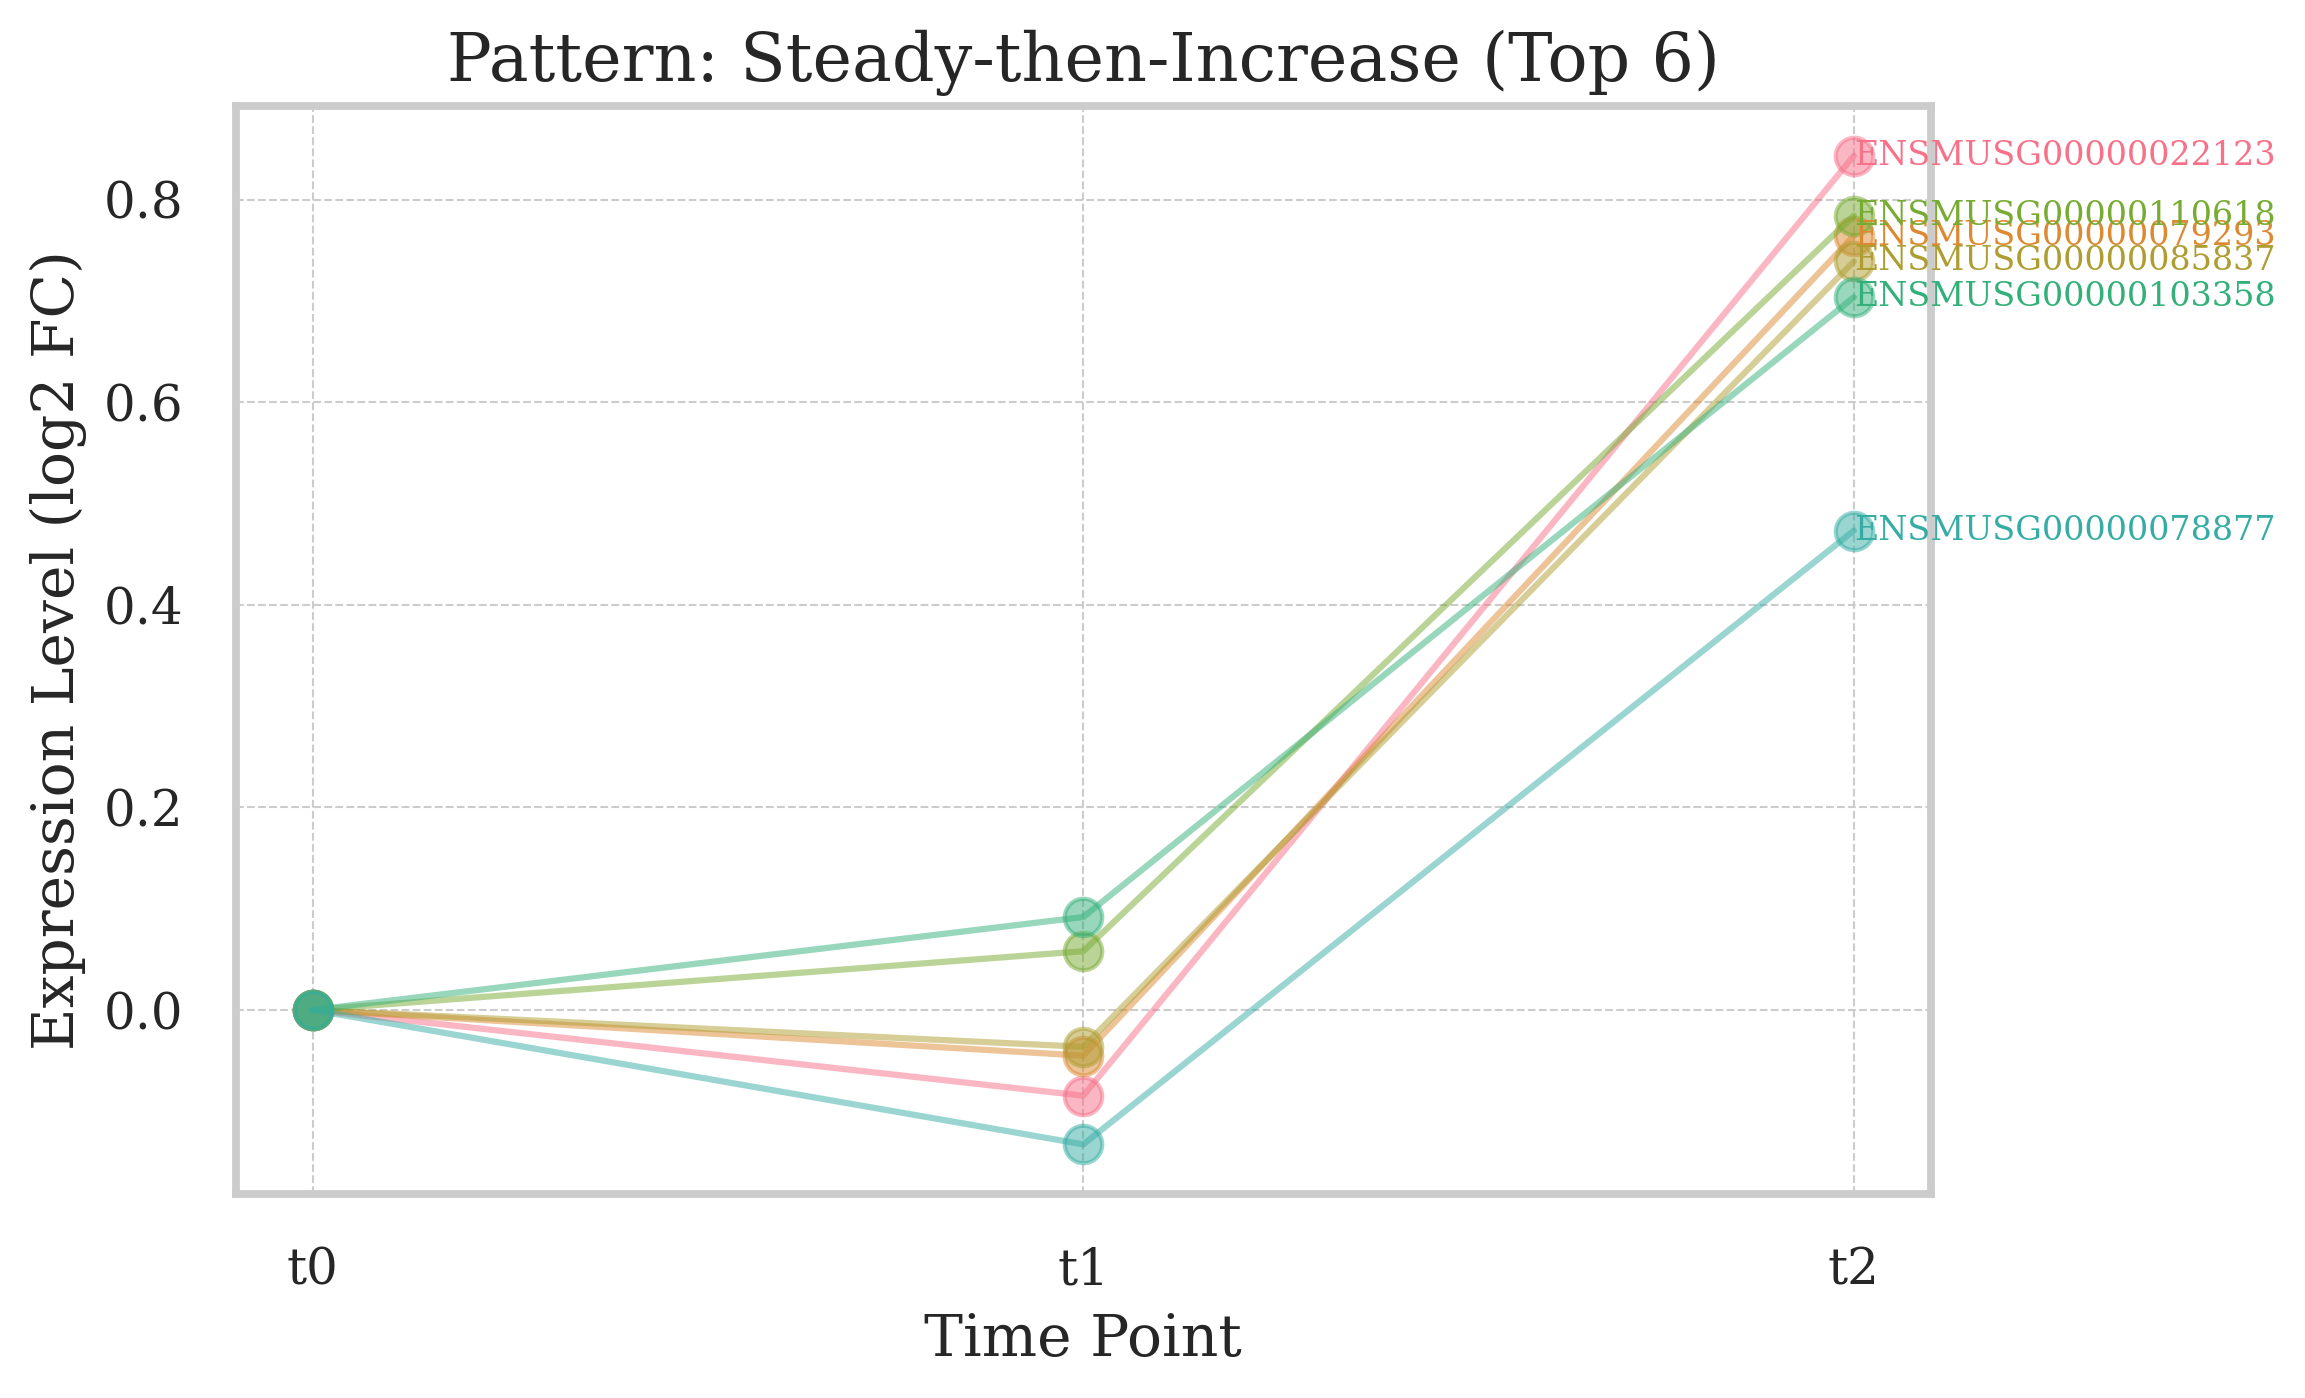

In [57]:
plot_mirna_pattern('Steady-then-Increase', top_n=6)


# Steady-then-Decrease

In [58]:
data_r9 = pd.read_excel(path3/"Mixed_mRNA_Steady-then-Decrease.xlsx")
data_r9.sort_values(by='FC_6_12', ascending=True, inplace=True)
data_r9.reset_index(drop=True)

ID     baseMean    FC_2_6   FC_6_12               pattern
0    ENSMUSG00000059305    12.754709 -0.110881 -2.351522  Steady-then-Decrease
1    ENSMUSG00000039865    24.289588  0.047238 -1.197674  Steady-then-Decrease
2    ENSMUSG00000123421    18.101102 -0.104549 -1.061888  Steady-then-Decrease
3    ENSMUSG00000046101    26.304335 -0.063986 -0.941391  Steady-then-Decrease
4    ENSMUSG00000136079    17.136755 -0.150356 -0.896473  Steady-then-Decrease
..                  ...          ...       ...       ...                   ...
128  ENSMUSG00000034064   778.961299 -0.019410 -0.181035  Steady-then-Decrease
129  ENSMUSG00000009013  1745.518582  0.041674 -0.179405  Steady-then-Decrease
130  ENSMUSG00000006676  3044.597951 -0.108907 -0.178583  Steady-then-Decrease
131  ENSMUSG00000030741   626.247234  0.079942 -0.170478  Steady-then-Decrease
132  ENSMUSG00000022200  2126.598573 -0.062757 -0.169442  Steady-then-Decrease

[133 rows x 5 columns]

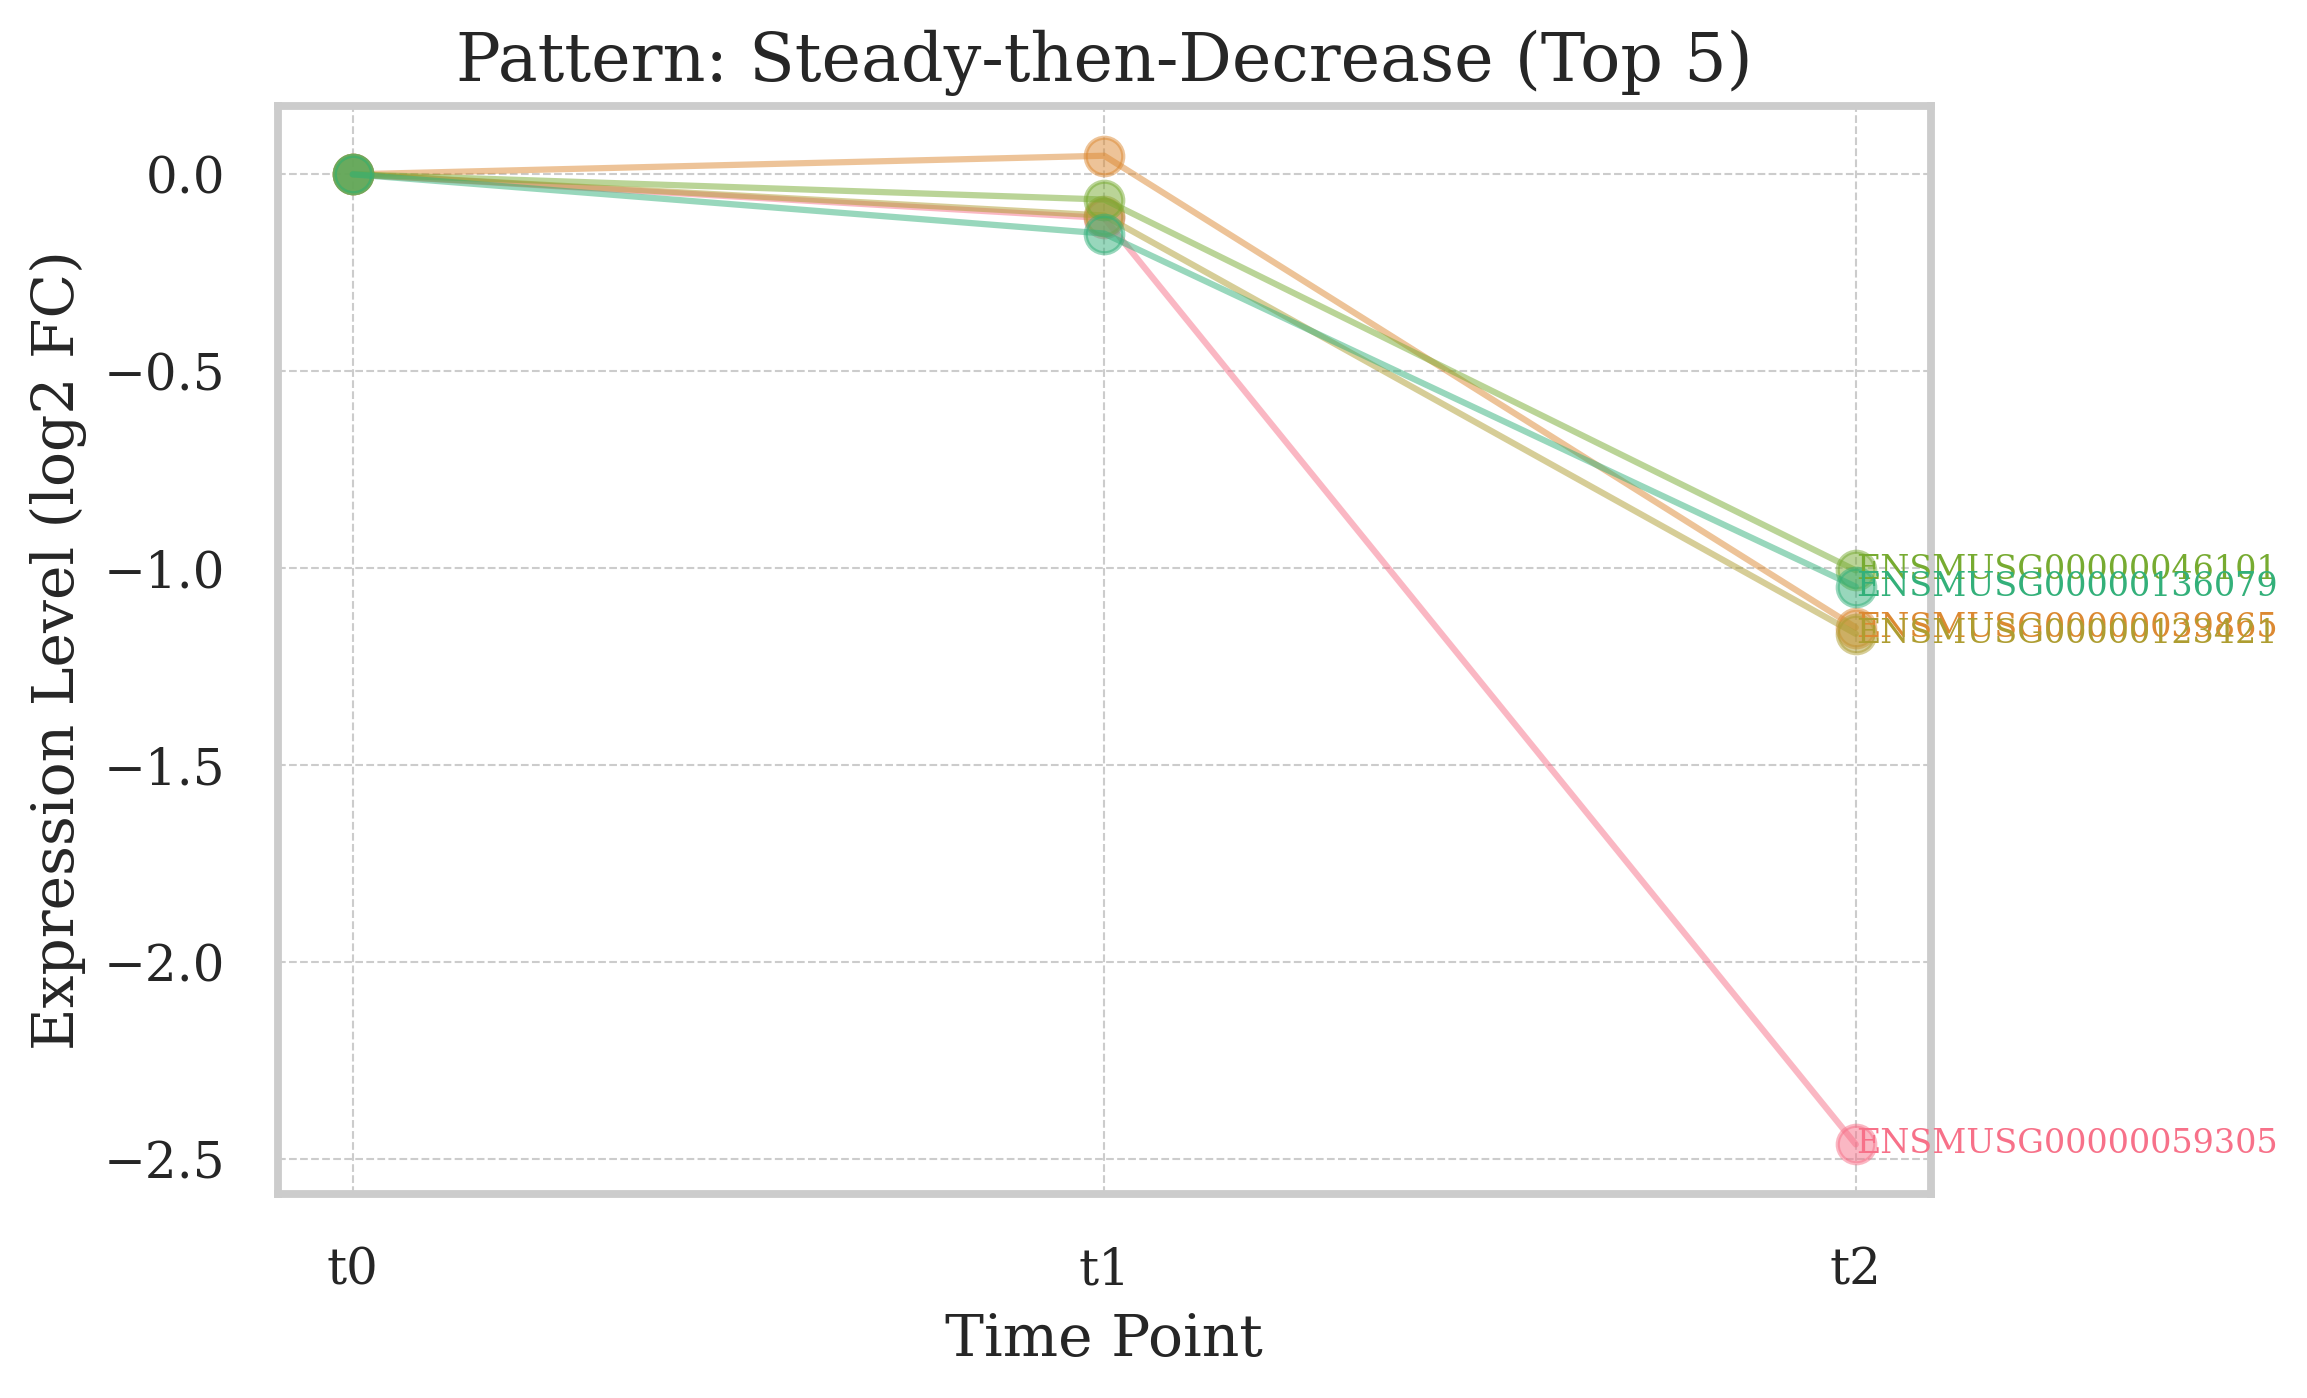

In [59]:
plot_mirna_pattern('Steady-then-Decrease', top_n=5)

# Decrease-then-Increase

In [60]:
data_r1 = pd.read_excel(path3/"Mixed_mRNA_Decrease-then-Increase.xlsx")

# Step 1: Subtract the columns row-wise and store in a new column
data_r1['expr_diff'] = data_r1['FC_6_12'] - data_r1['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r1_sorted = data_r1.sort_values(by='expr_diff', ascending=False,inplace=True)

data_r1.reset_index(drop=True, inplace=True)

data_r1

ID    baseMean    FC_2_6   FC_6_12  \
0   ENSMUSG00000102610   13.010392 -1.524275  1.978299   
1   ENSMUSG00000026581   21.837071 -1.354312  1.387679   
2   ENSMUSG00000142531   13.369055 -0.330767  2.342963   
3   ENSMUSG00000040592   12.047040 -1.131341  1.515070   
4   ENSMUSG00000030577   17.167044 -1.112782  1.170765   
5   ENSMUSG00000114566   22.110870 -1.129147  1.109270   
6   ENSMUSG00000028186   24.037484 -0.911060  0.978842   
7   ENSMUSG00000024552   43.303065 -0.838173  1.048522   
8   ENSMUSG00000121471   18.787849 -0.207631  1.622566   
9   ENSMUSG00000043164   88.608249 -0.838349  0.960895   
10  ENSMUSG00000003379   12.379511 -0.352714  1.440166   
11  ENSMUSG00000030789   17.839496 -0.601575  1.181857   
12  ENSMUSG00000104213   21.532131 -0.577623  1.054748   
13  ENSMUSG00000109459   28.171097 -0.864767  0.757180   
14  ENSMUSG00000023949   62.814077 -0.485795  0.924561   
15  ENSMUSG00000086822   55.020587 -0.700767  0.699321   
16  ENSMUSG00000037627  240.706491 -0.573674  0.696613   
17  ENSMUSG00000121024   19.124834 -0.262891  0.962796   
18  ENSMUSG00000024677   42.740258 -0.309040  0.766987   
19  ENSMUSG00000022262  624.752999 -0.493802  0.562207   
20  ENSMUSG00000108175   60.192372 -0.457554  0.573521   
21  ENSMUSG00000113831  150.960342 -0.432225  0.394727   
22  ENSMUSG00000026395  276.541208 -0.262704  0.535378   
23  ENSMUSG00000057396  164.042634 -0.246373  0.429268   
24  ENSMUSG00000022449  420.148086 -0.207989  0.443937   
25  ENSMUSG00000087231  208.898906 -0.188197  0.415636   
26  ENSMUSG00000003929  350.403833 -0.251479  0.280305   

                   pattern  expr_diff  
0   Decrease-then-Increase   3.502574  
1   Decrease-then-Increase   2.741991  
2   Decrease-then-Increase   2.673730  
3   Decrease-then-Increase   2.646411  
4   Decrease-then-Increase   2.283547  
5   Decrease-then-Increase   2.238417  
6   Decrease-then-Increase   1.889902  
7   Decrease-then-Increase   1.886696  
8   Decrease-then-Increase   1.830197  
9   Decrease-then-Increase   1.799245  
10  Decrease-then-Increase   1.792880  
11  Decrease-then-Increase   1.783432  
12  Decrease-then-Increase   1.632371  
13  Decrease-then-Increase   1.621946  
14  Decrease-then-Increase   1.410355  
15  Decrease-then-Increase   1.400088  
16  Decrease-then-Increase   1.270287  
17  Decrease-then-Increase   1.225687  
18  Decrease-then-Increase   1.076028  
19  Decrease-then-Increase   1.056008  
20  Decrease-then-Increase   1.031076  
21  Decrease-then-Increase   0.826951  
22  Decrease-then-Increase   0.798083  
23  Decrease-then-Increase   0.675641  
24  Decrease-then-Increase   0.651926  
25  Decrease-then-Increase   0.603833  
26  Decrease-then-Increase   0.531784

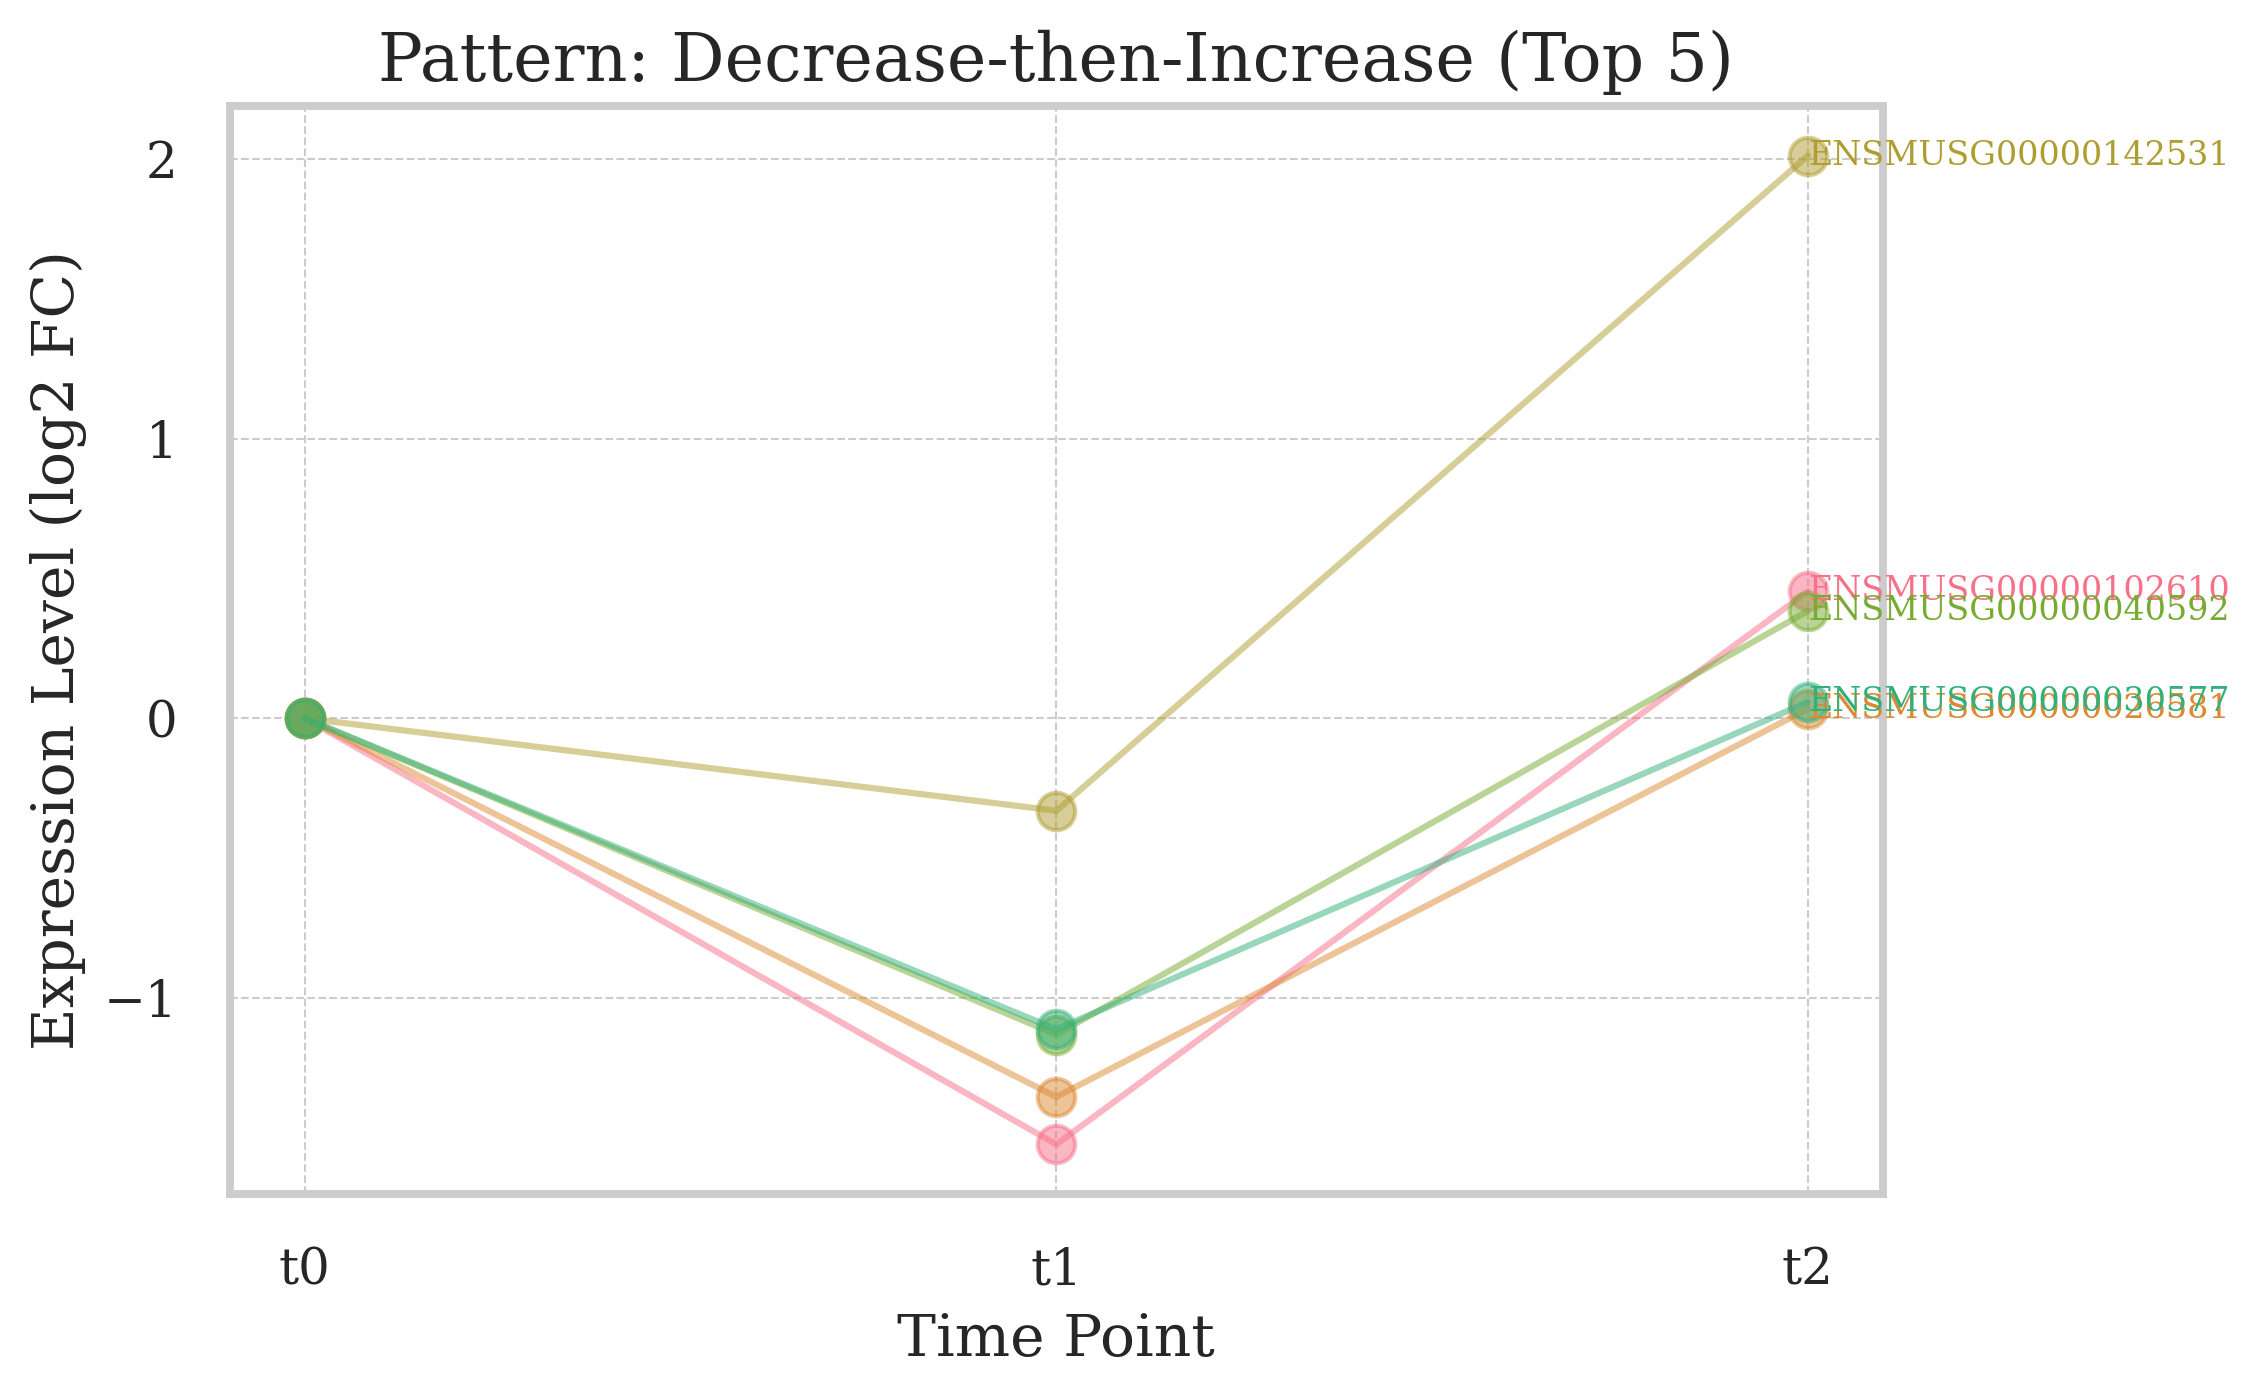

In [61]:
plot_mirna_pattern('Decrease-then-Increase', top_n=5)


# Increase-then-Decrease

In [62]:
data_r3 = pd.read_excel(path3/"Mixed_mRNA_Increase-then-Decrease.xlsx")

# Step 1: Subtract the columns row-wise and store in a new column
data_r3['expr_diff'] = data_r3['FC_6_12'] - data_r3['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r3_sorted = data_r3.sort_values(by='expr_diff', ascending=True,inplace=True)

data_r3.reset_index(drop=True, inplace=True)

data_r3

ID   baseMean    FC_2_6   FC_6_12                 pattern  \
0  ENSMUSG00000020660  81.873234  2.371552 -2.421605  Increase-then-Decrease   
1  ENSMUSG00000045394  29.573298  0.835795 -2.064508  Increase-then-Decrease   
2  ENSMUSG00000110453  13.121094  0.433473 -1.339570  Increase-then-Decrease   
3  ENSMUSG00000064369  25.225231  0.753155 -0.877004  Increase-then-Decrease   
4  ENSMUSG00000028716  27.928789  0.208563 -1.374209  Increase-then-Decrease   
5  ENSMUSG00000020884  20.252965  0.319450 -1.145419  Increase-then-Decrease   
6  ENSMUSG00000125782  11.134252  0.220875 -1.211662  Increase-then-Decrease   
7  ENSMUSG00000050558  18.581810  0.474278 -0.951714  Increase-then-Decrease   
8  ENSMUSG00000056055  50.050672  0.270525 -0.723853  Increase-then-Decrease   
9  ENSMUSG00000074971  84.441099  0.169491 -0.616303  Increase-then-Decrease   

   expr_diff  
0  -4.793156  
1  -2.900303  
2  -1.773042  
3  -1.630158  
4  -1.582772  
5  -1.464868  
6  -1.432537  
7  -1.425992  
8  -0.994378  
9  -0.785794

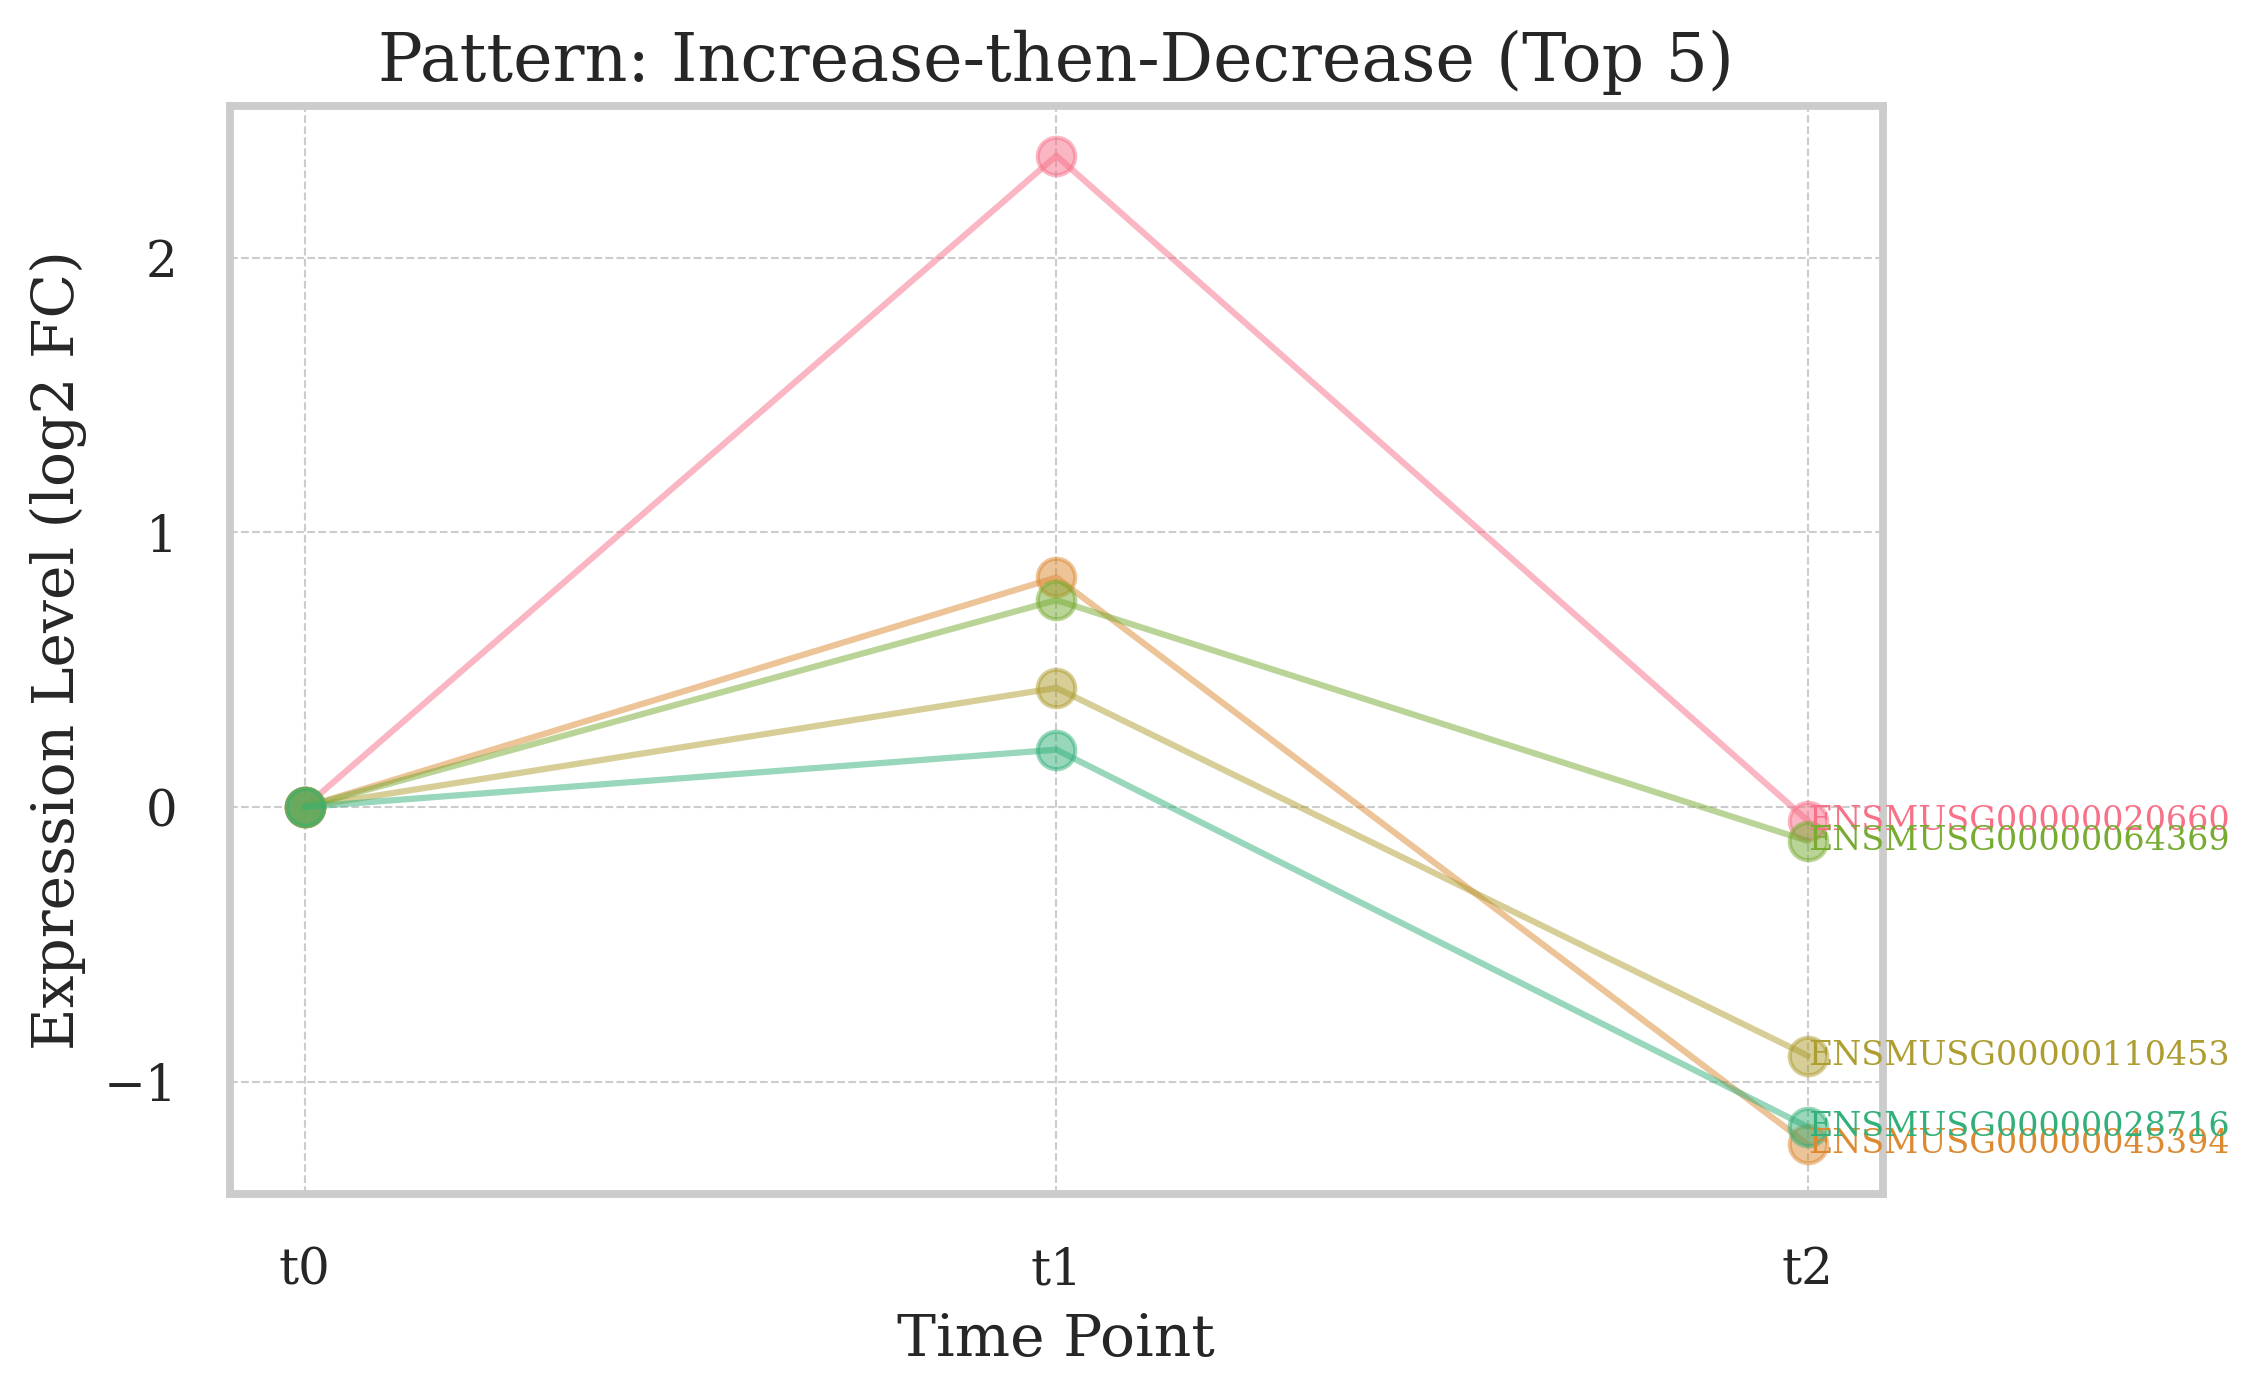

In [63]:
plot_mirna_pattern('Increase-then-Decrease', top_n=5)


# Gradual-Decrease

In [64]:
data_r4 = pd.read_excel(path3/"Mixed_mRNA_Gradual-Decrease.xlsx")

# Step 1: add the columns row-wise and store in a new column
data_r4['expr_sum'] = data_r4['FC_6_12'] + data_r4['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r4_sorted = data_r4.sort_values(by='expr_sum', ascending=True,inplace=True)

data_r4.reset_index(drop=True, inplace=True)

data_r4

ID     baseMean    FC_2_6   FC_6_12           pattern  \
0    ENSMUSG00000045337    48.971125 -1.240267 -1.951127  Gradual-Decrease   
1    ENSMUSG00000127502    20.078634 -1.515497 -1.492482  Gradual-Decrease   
2    ENSMUSG00000115625   171.008156 -0.935912 -1.955364  Gradual-Decrease   
3    ENSMUSG00000086607   221.404032 -1.343089 -1.547671  Gradual-Decrease   
4    ENSMUSG00000087001    26.148439 -1.127177 -1.763199  Gradual-Decrease   
..                  ...          ...       ...       ...               ...   
469  ENSMUSG00000032570  4596.995522 -0.209895 -0.211629  Gradual-Decrease   
470  ENSMUSG00000062590   621.972928 -0.207416 -0.213124  Gradual-Decrease   
471  ENSMUSG00000030894  2563.961874 -0.170832 -0.247922  Gradual-Decrease   
472  ENSMUSG00000023079  1169.640473 -0.190073 -0.217290  Gradual-Decrease   
473  ENSMUSG00000032743  1270.691908 -0.174674 -0.196596  Gradual-Decrease   

     expr_sum  
0   -3.191394  
1   -3.007979  
2   -2.891276  
3   -2.890760  
4   -2.890376  
..        ...  
469 -0.421524  
470 -0.420540  
471 -0.418754  
472 -0.407364  
473 -0.371270  

[474 rows x 6 columns]

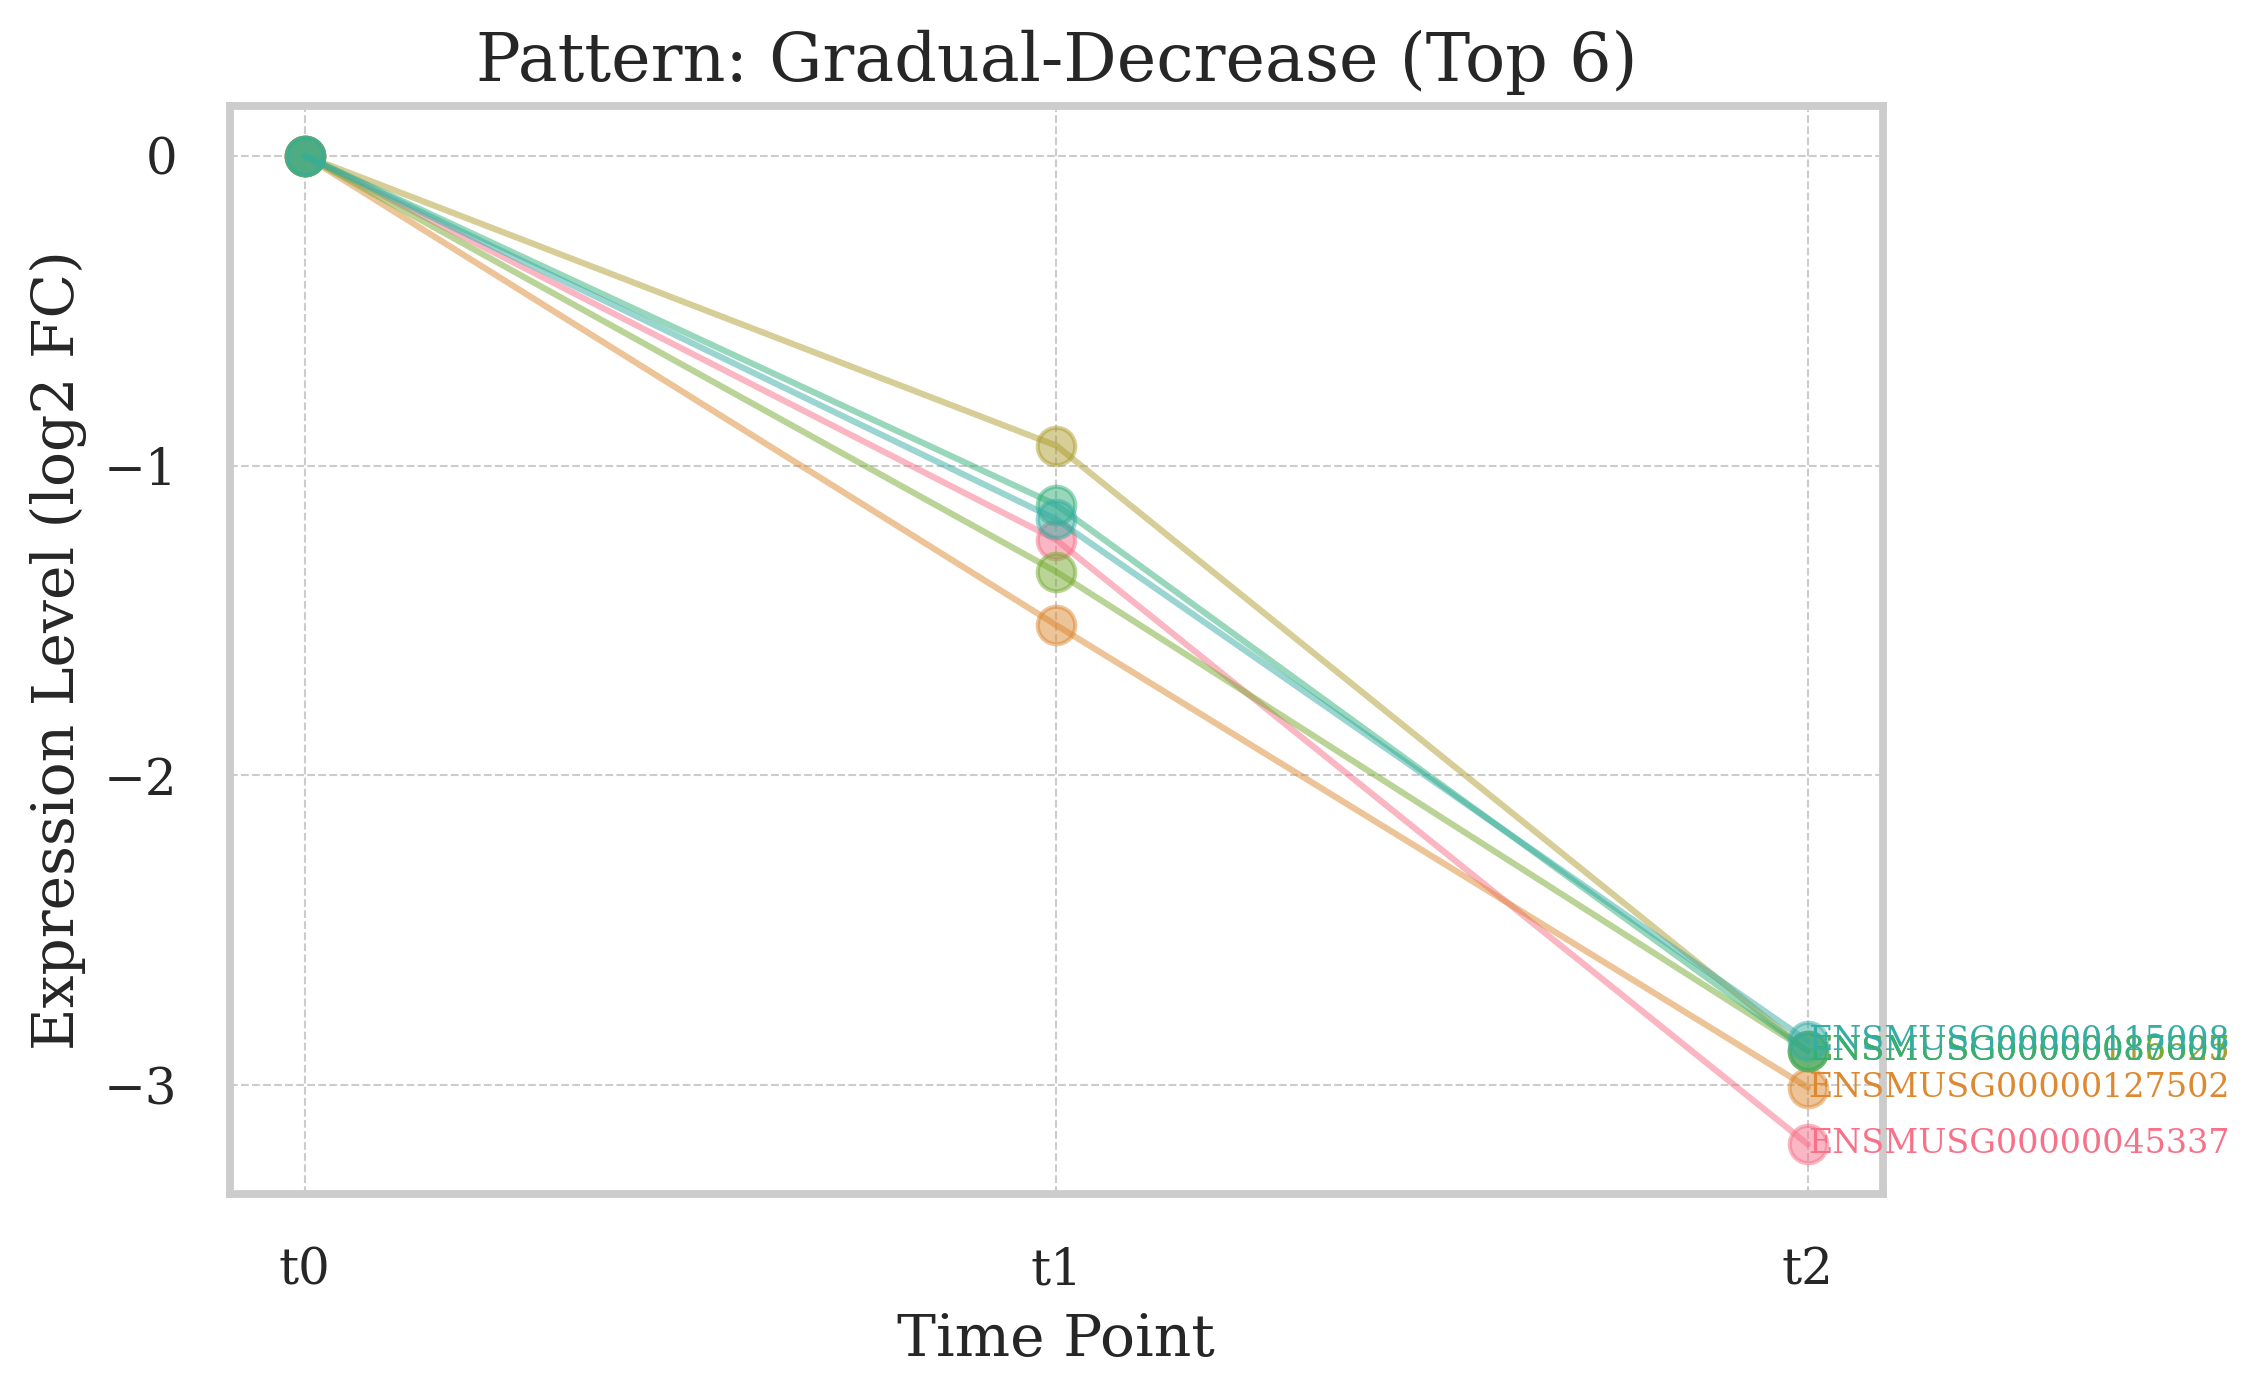

In [66]:
plot_mirna_pattern('Gradual-Decrease', top_n=6)


# Gradual-Increase

In [67]:
data_r7 = pd.read_excel(path3/"Mixed_mRNA_Gradual-Increase.xlsx")

# Step 1: add the columns row-wise and store in a new column
data_r7['expr_sum'] = data_r7['FC_6_12'] + data_r7['FC_2_6']

# Step 2: Sort the DataFrame based on the new column
data_r7_sorted = data_r7.sort_values(by='expr_sum', ascending=False,inplace=True)

data_r7.reset_index(drop=True, inplace=True)

data_r7

ID      baseMean    FC_2_6   FC_6_12           pattern  \
0   ENSMUSG00000004707     17.444917  1.086365  0.940595  Gradual-Increase   
1   ENSMUSG00000110924     26.576092  0.832370  0.896269  Gradual-Increase   
2   ENSMUSG00000141743     13.929759  0.204093  1.385601  Gradual-Increase   
3   ENSMUSG00000107677     38.260120  0.631481  0.874252  Gradual-Increase   
4   ENSMUSG00000120254     19.523982  0.433889  1.067947  Gradual-Increase   
5   ENSMUSG00000017737     25.388866  0.497479  0.939805  Gradual-Increase   
6   ENSMUSG00000105594     79.496538  0.721754  0.697024  Gradual-Increase   
7   ENSMUSG00000051486     95.050004  0.534841  0.860766  Gradual-Increase   
8   ENSMUSG00000047759     66.767796  0.584598  0.717791  Gradual-Increase   
9   ENSMUSG00000051678     61.448015  0.493595  0.753079  Gradual-Increase   
10  ENSMUSG00000111110     44.545401  0.435083  0.796267  Gradual-Increase   
11  ENSMUSG00000051599     67.381563  0.468982  0.685145  Gradual-Increase   
12  ENSMUSG00000095041   2969.703954  0.417304  0.732002  Gradual-Increase   
13  ENSMUSG00000039106     83.799219  0.574332  0.499387  Gradual-Increase   
14  ENSMUSG00000033220     88.334844  0.370694  0.617906  Gradual-Increase   
15  ENSMUSG00000071753  32276.033851  0.237313  0.709464  Gradual-Increase   
16  ENSMUSG00000121301     44.803842  0.349121  0.557336  Gradual-Increase   
17  ENSMUSG00000136702    121.044694  0.337610  0.542064  Gradual-Increase   
18  ENSMUSG00000073418   1668.790788  0.480663  0.383127  Gradual-Increase   
19  ENSMUSG00000064023     46.609225  0.233824  0.627405  Gradual-Increase   
20  ENSMUSG00000076617    247.534178  0.305742  0.540884  Gradual-Increase   
21  ENSMUSG00000050967    760.982635  0.361226  0.470278  Gradual-Increase   
22  ENSMUSG00000044734    186.376320  0.234324  0.562218  Gradual-Increase   
23  ENSMUSG00000041245   1358.498649  0.277478  0.483276  Gradual-Increase   
24  ENSMUSG00000056145    343.264729  0.282928  0.454129  Gradual-Increase   
25  ENSMUSG00000054640   4734.176621  0.342367  0.391413  Gradual-Increase   
26  ENSMUSG00000120261    115.511326  0.268369  0.433944  Gradual-Increase   
27  ENSMUSG00000050587   1128.703604  0.222440  0.438433  Gradual-Increase   
28  ENSMUSG00000042751   2932.077571  0.278817  0.316273  Gradual-Increase   
29  ENSMUSG00000036890    740.355558  0.224490  0.359262  Gradual-Increase   
30  ENSMUSG00000041439   1322.543481  0.349399  0.216599  Gradual-Increase   
31  ENSMUSG00000022973   3884.058694  0.254622  0.305130  Gradual-Increase   
32  ENSMUSG00000039231    409.364885  0.235802  0.279058  Gradual-Increase   
33  ENSMUSG00000039126   1430.932332  0.217528  0.250919  Gradual-Increase   
34  ENSMUSG00000001525   6272.858595  0.223685  0.219800  Gradual-Increase   
35  ENSMUSG00000018750   5830.880975  0.206793  0.186939  Gradual-Increase   
36  ENSMUSG00000021838   2050.201048  0.192288  0.193642  Gradual-Increase   
37  ENSMUSG00000039849   1806.063105  0.195391  0.186011  Gradual-Increase   
38  ENSMUSG00000024392   4669.647425  0.183732  0.191014  Gradual-Increase   
39  ENSMUSG00000037685   5251.408695  0.176533  0.195053  Gradual-Increase   

    expr_sum  
0   2.026960  
1   1.728638  
2   1.589694  
3   1.505733  
4   1.501836  
5   1.437285  
6   1.418778  
7   1.395607  
8   1.302388  
9   1.246673  
10  1.231350  
11  1.154127  
12  1.149307  
13  1.073719  
14  0.988601  
15  0.946777  
16  0.906456  
17  0.879674  
18  0.863790  
19  0.861229  
20  0.846627  
21  0.831504  
22  0.796542  
23  0.760754  
24  0.737058  
25  0.733780  
26  0.702313  
27  0.660873  
28  0.595090  
29  0.583752  
30  0.565998  
31  0.559752  
32  0.514860  
33  0.468447  
34  0.443485  
35  0.393732  
36  0.385930  
37  0.381402  
38  0.374747  
39  0.371587

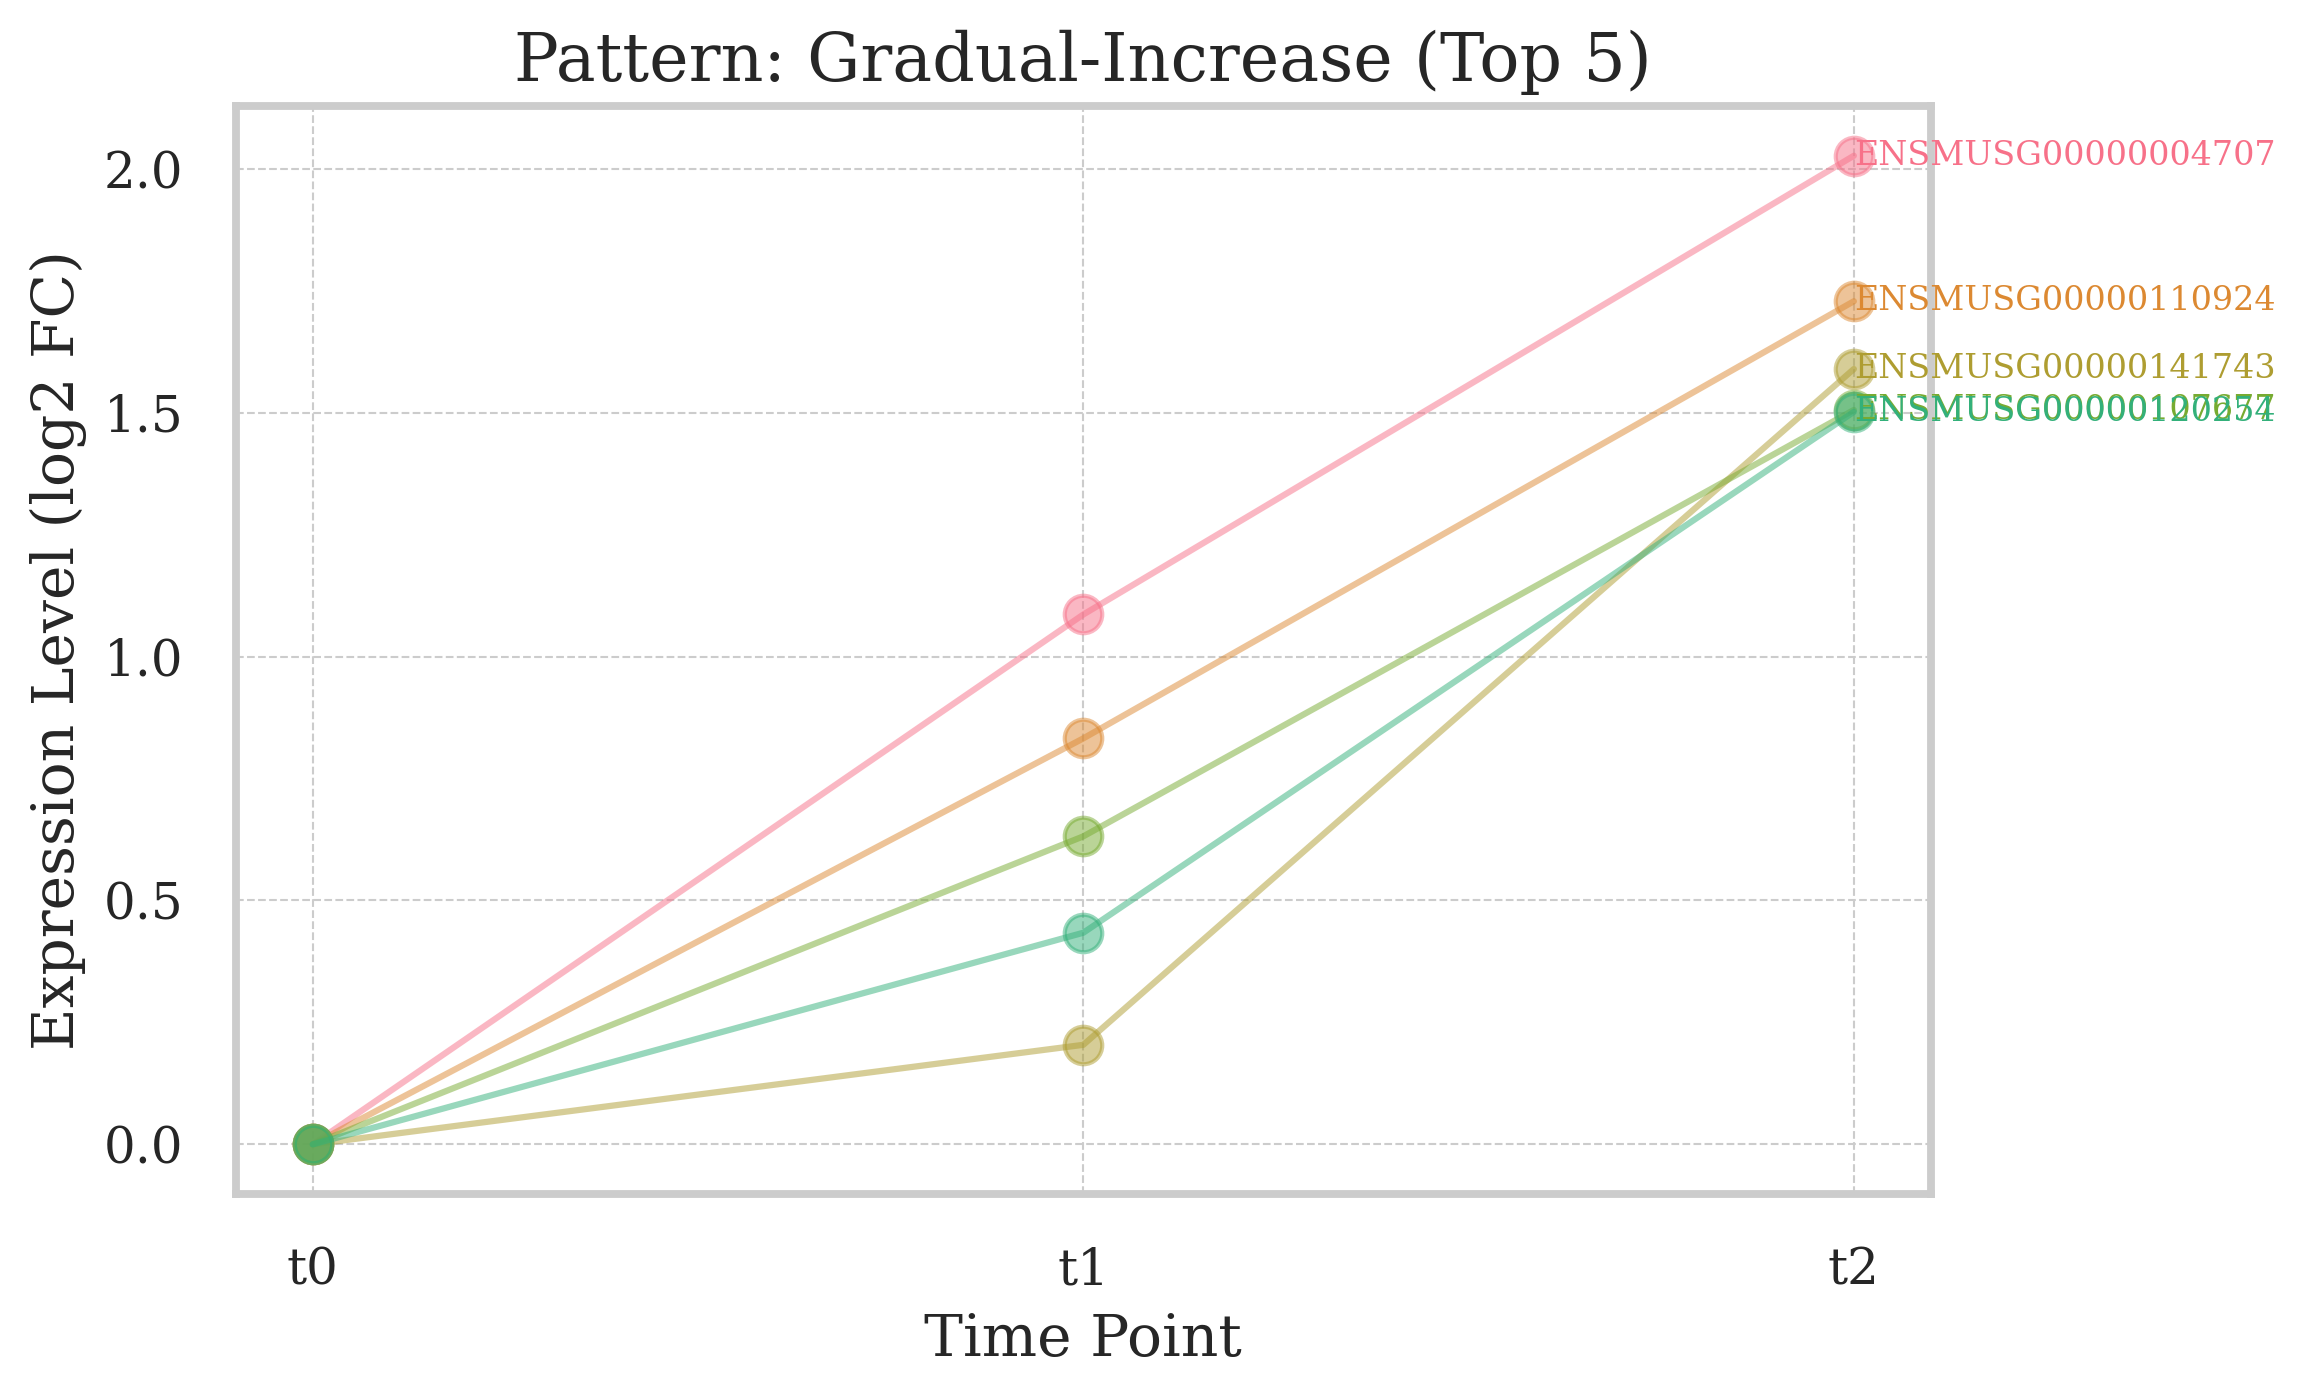

In [68]:
plot_mirna_pattern('Gradual-Increase', top_n=5)


# All the plots

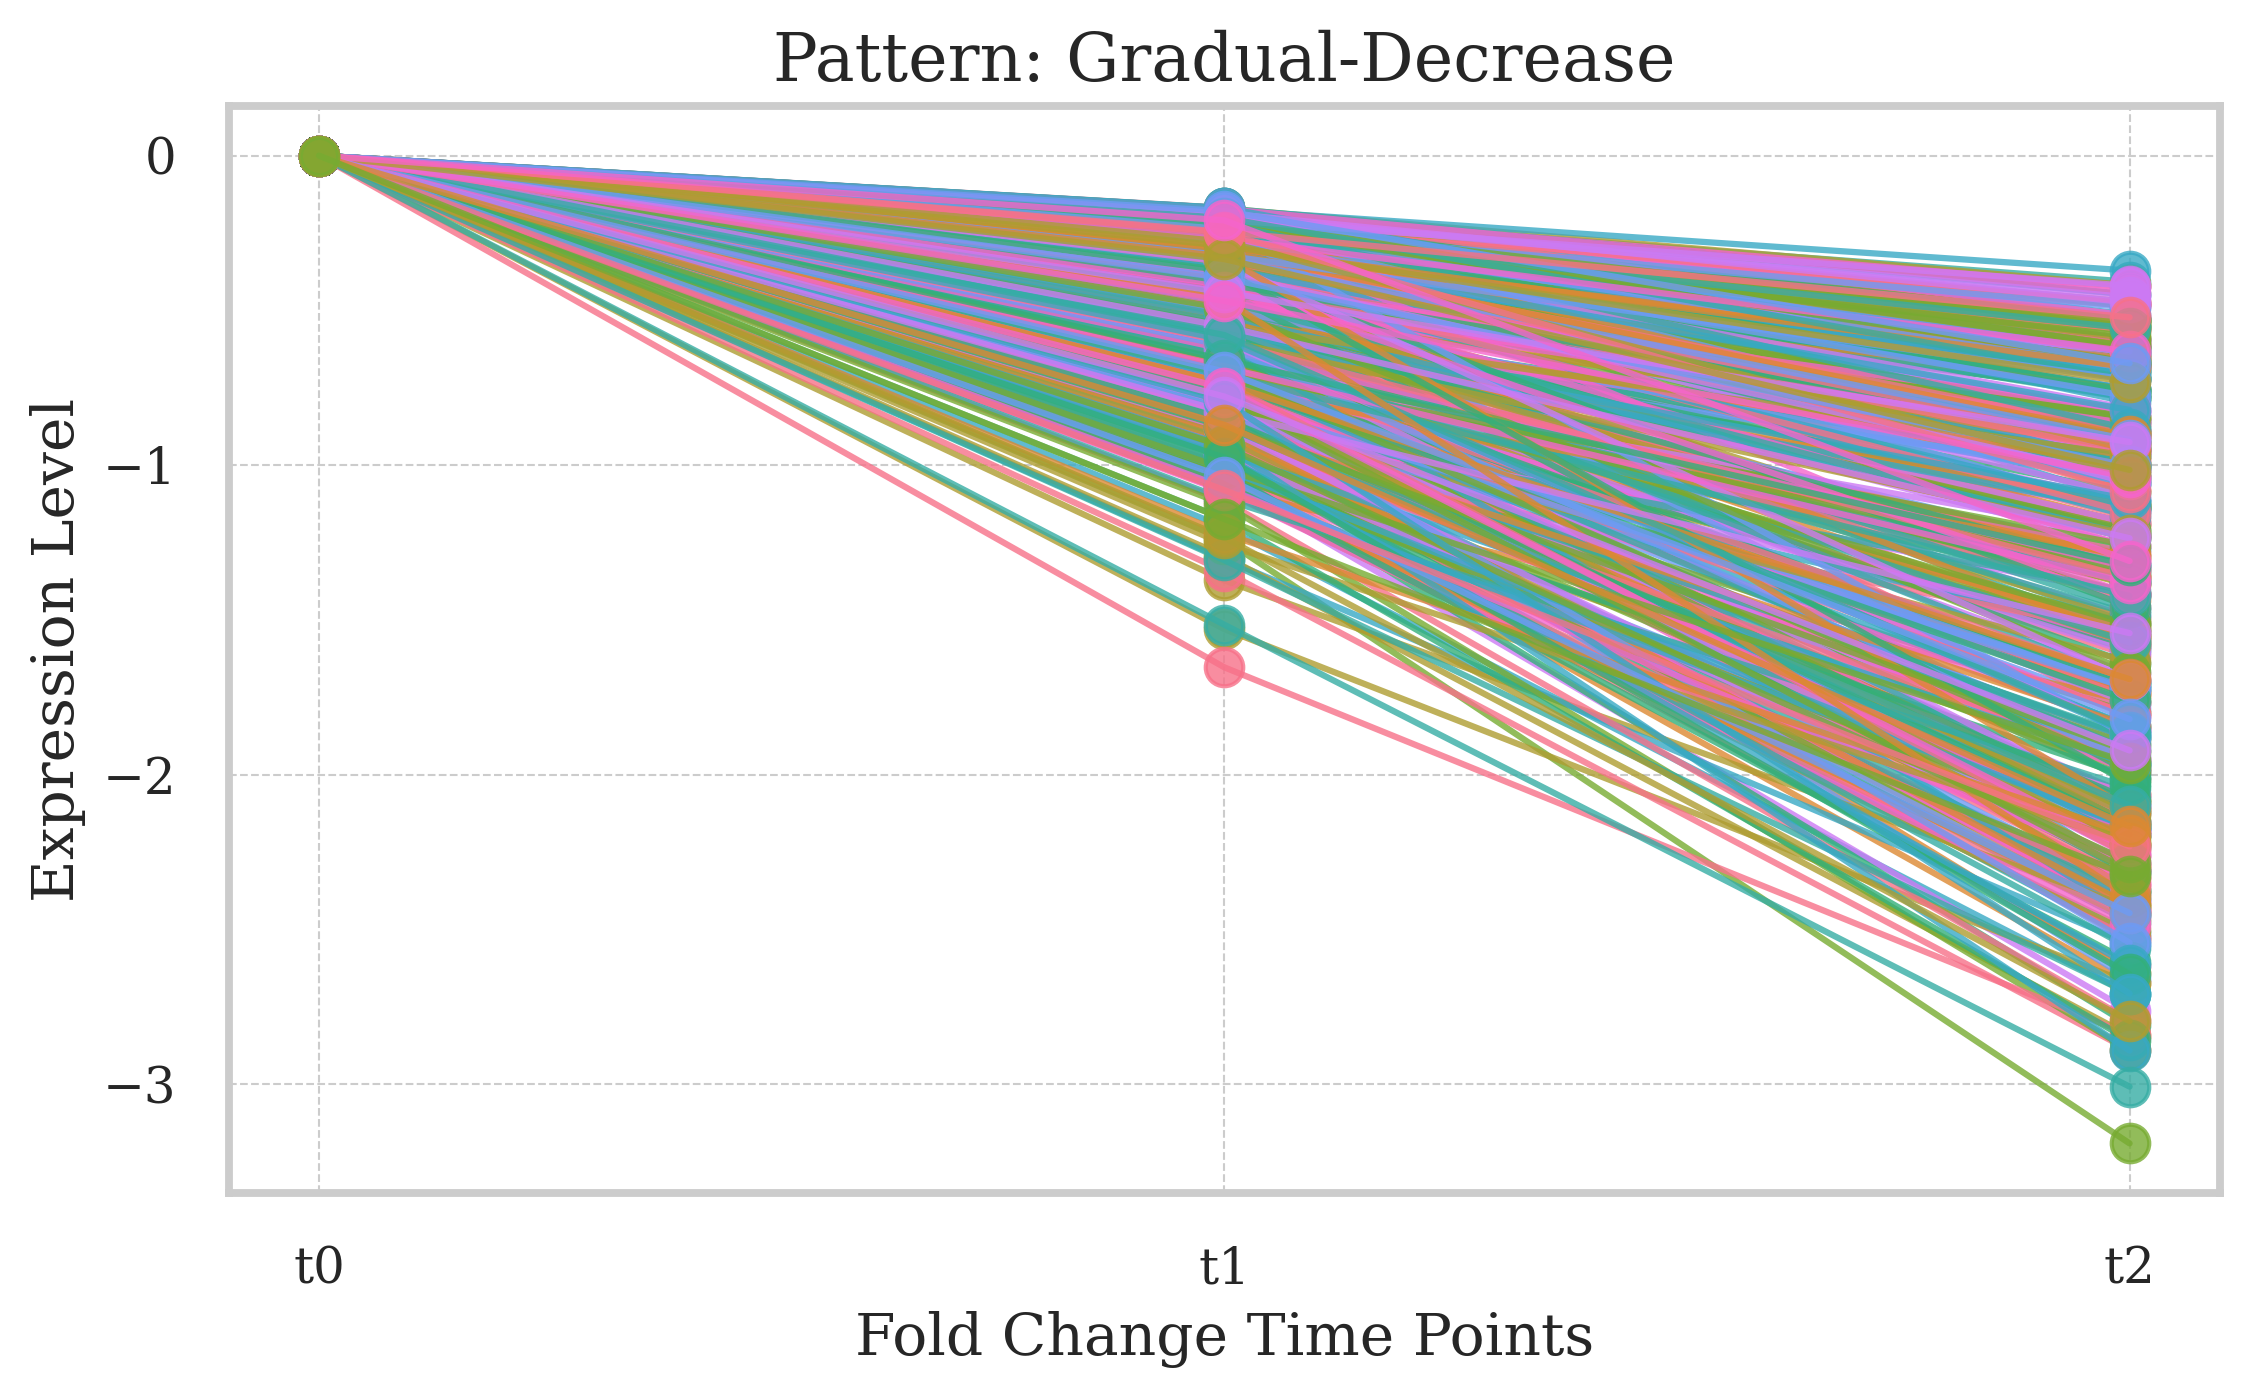

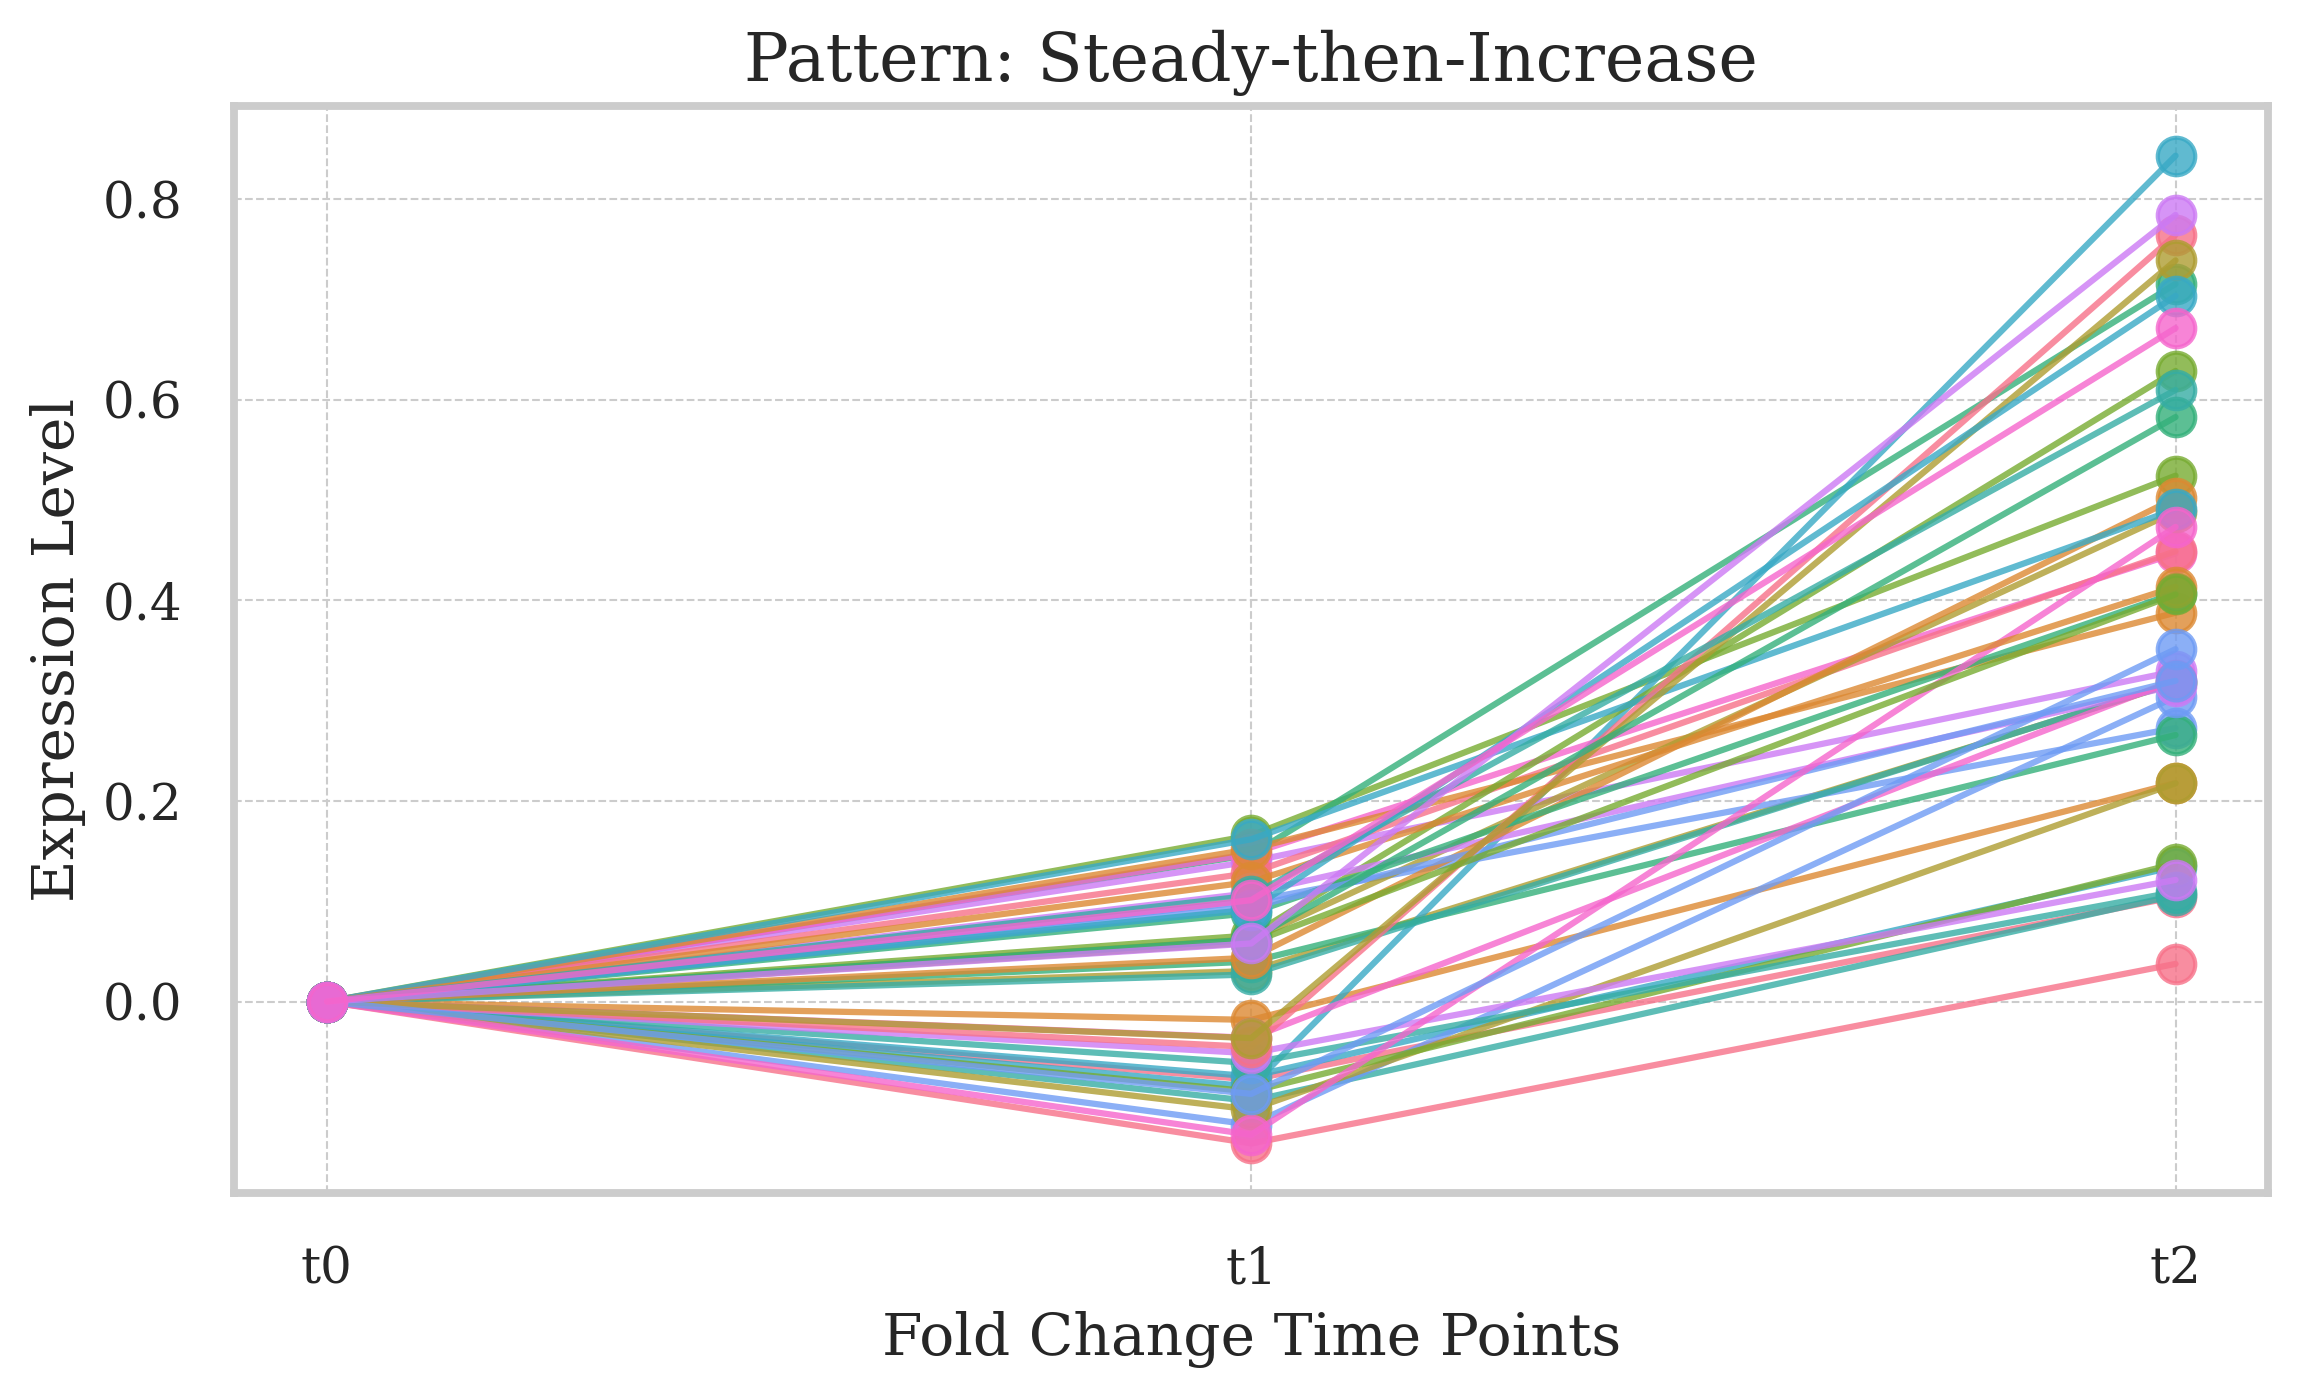

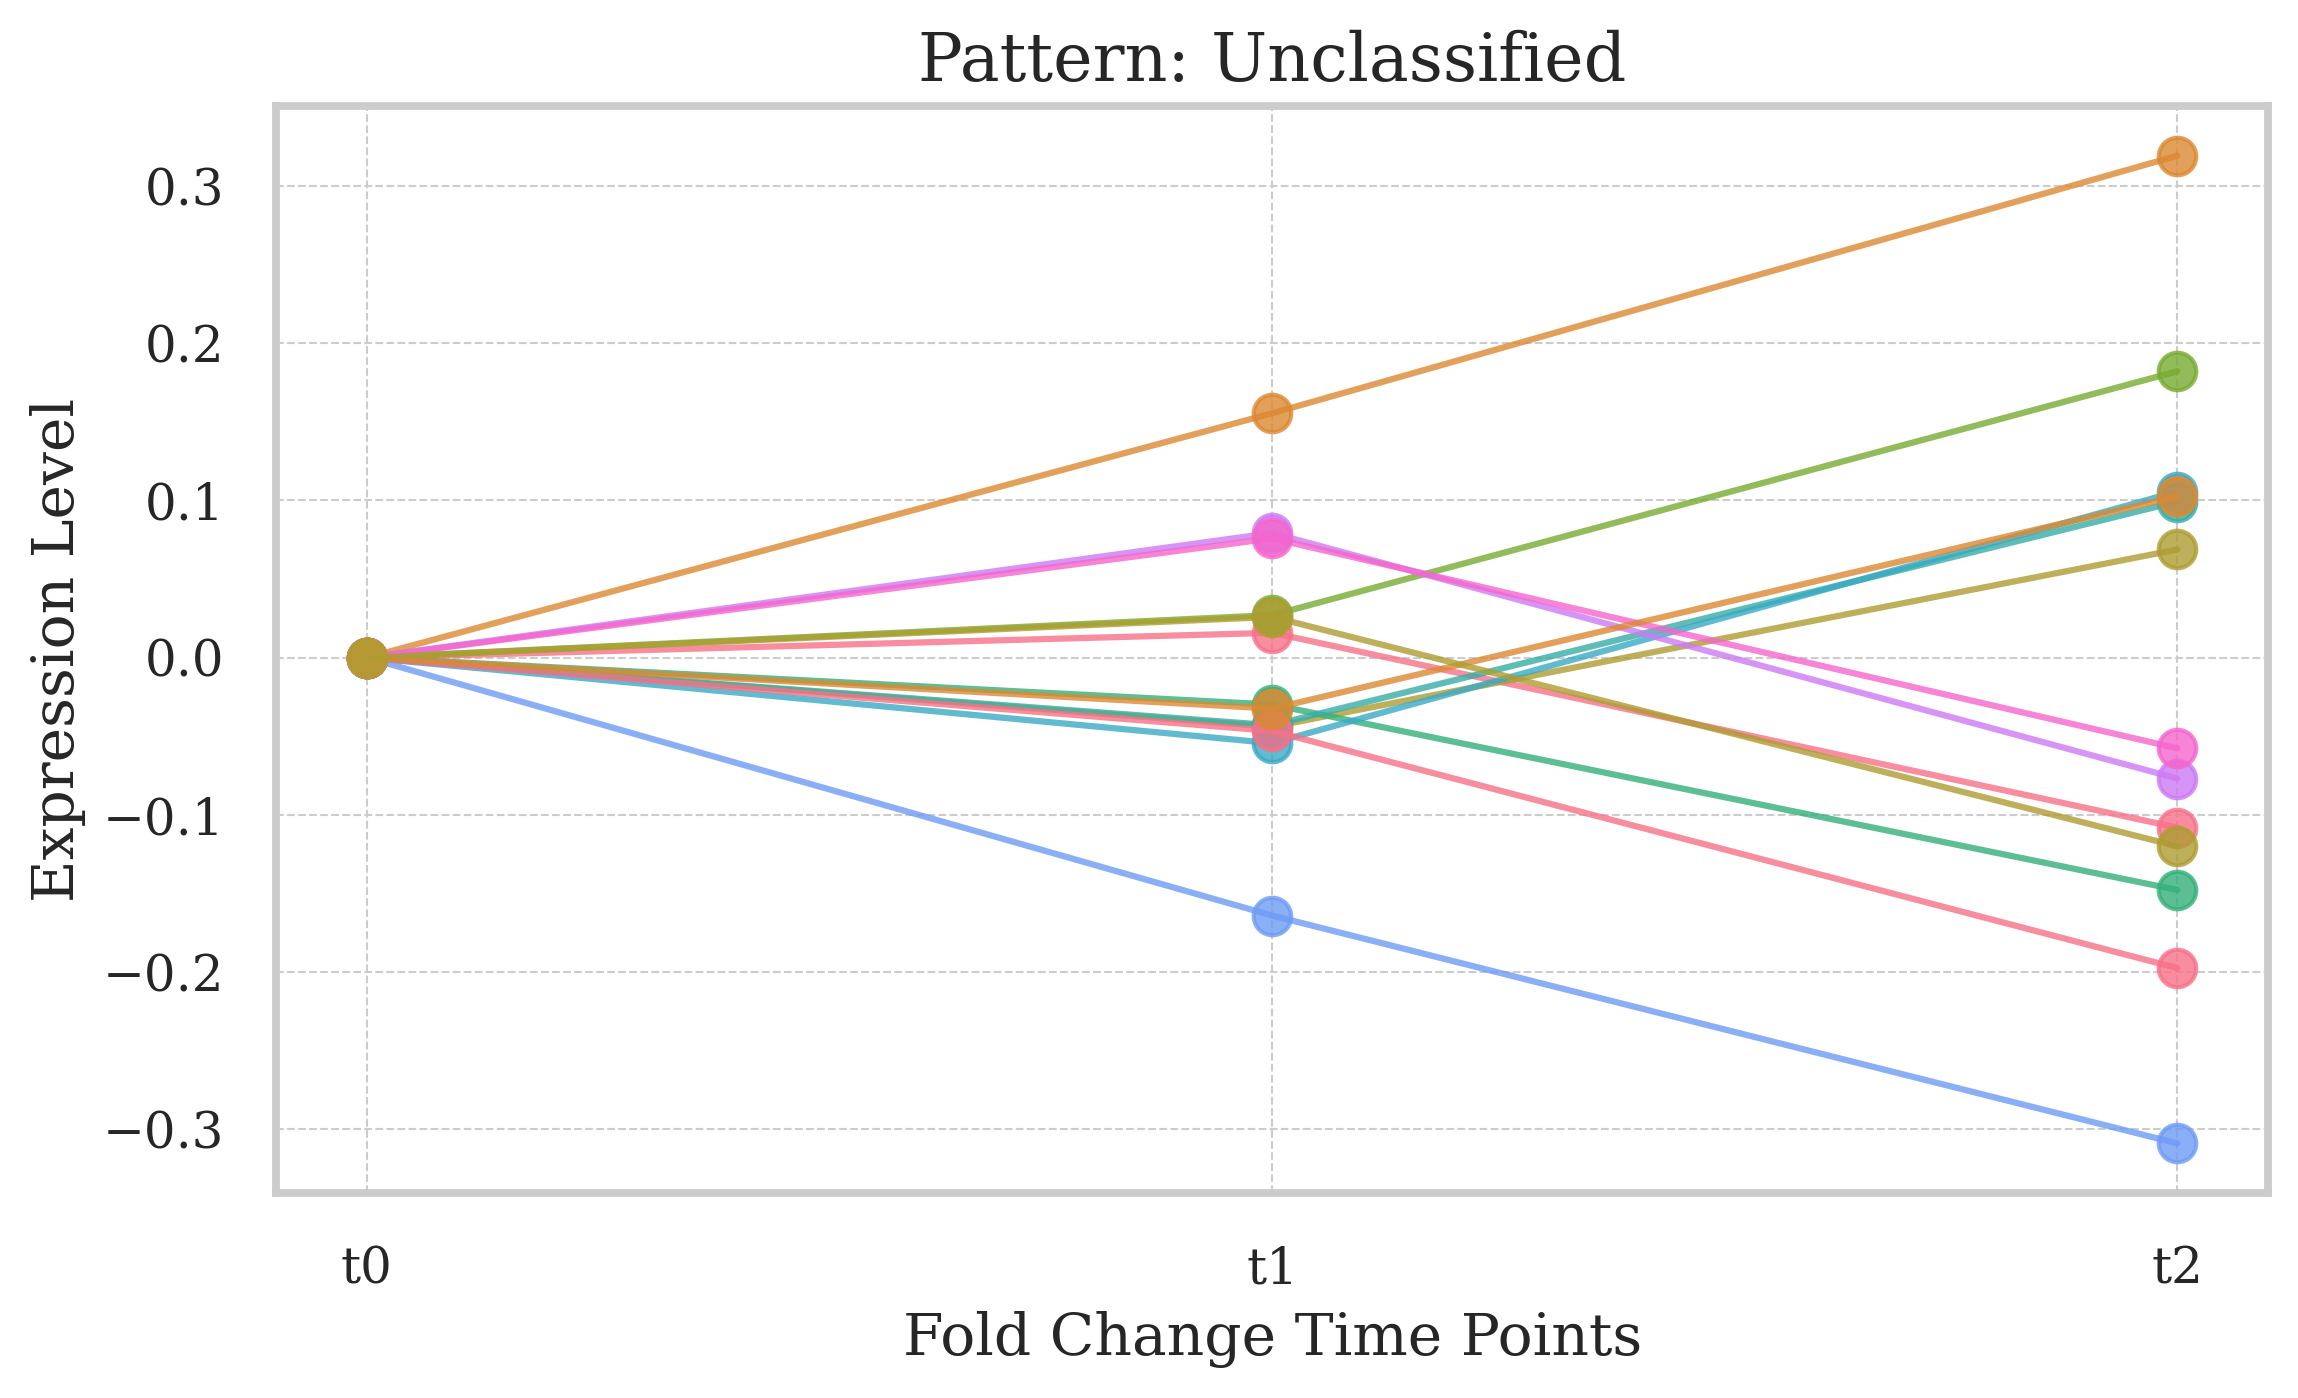

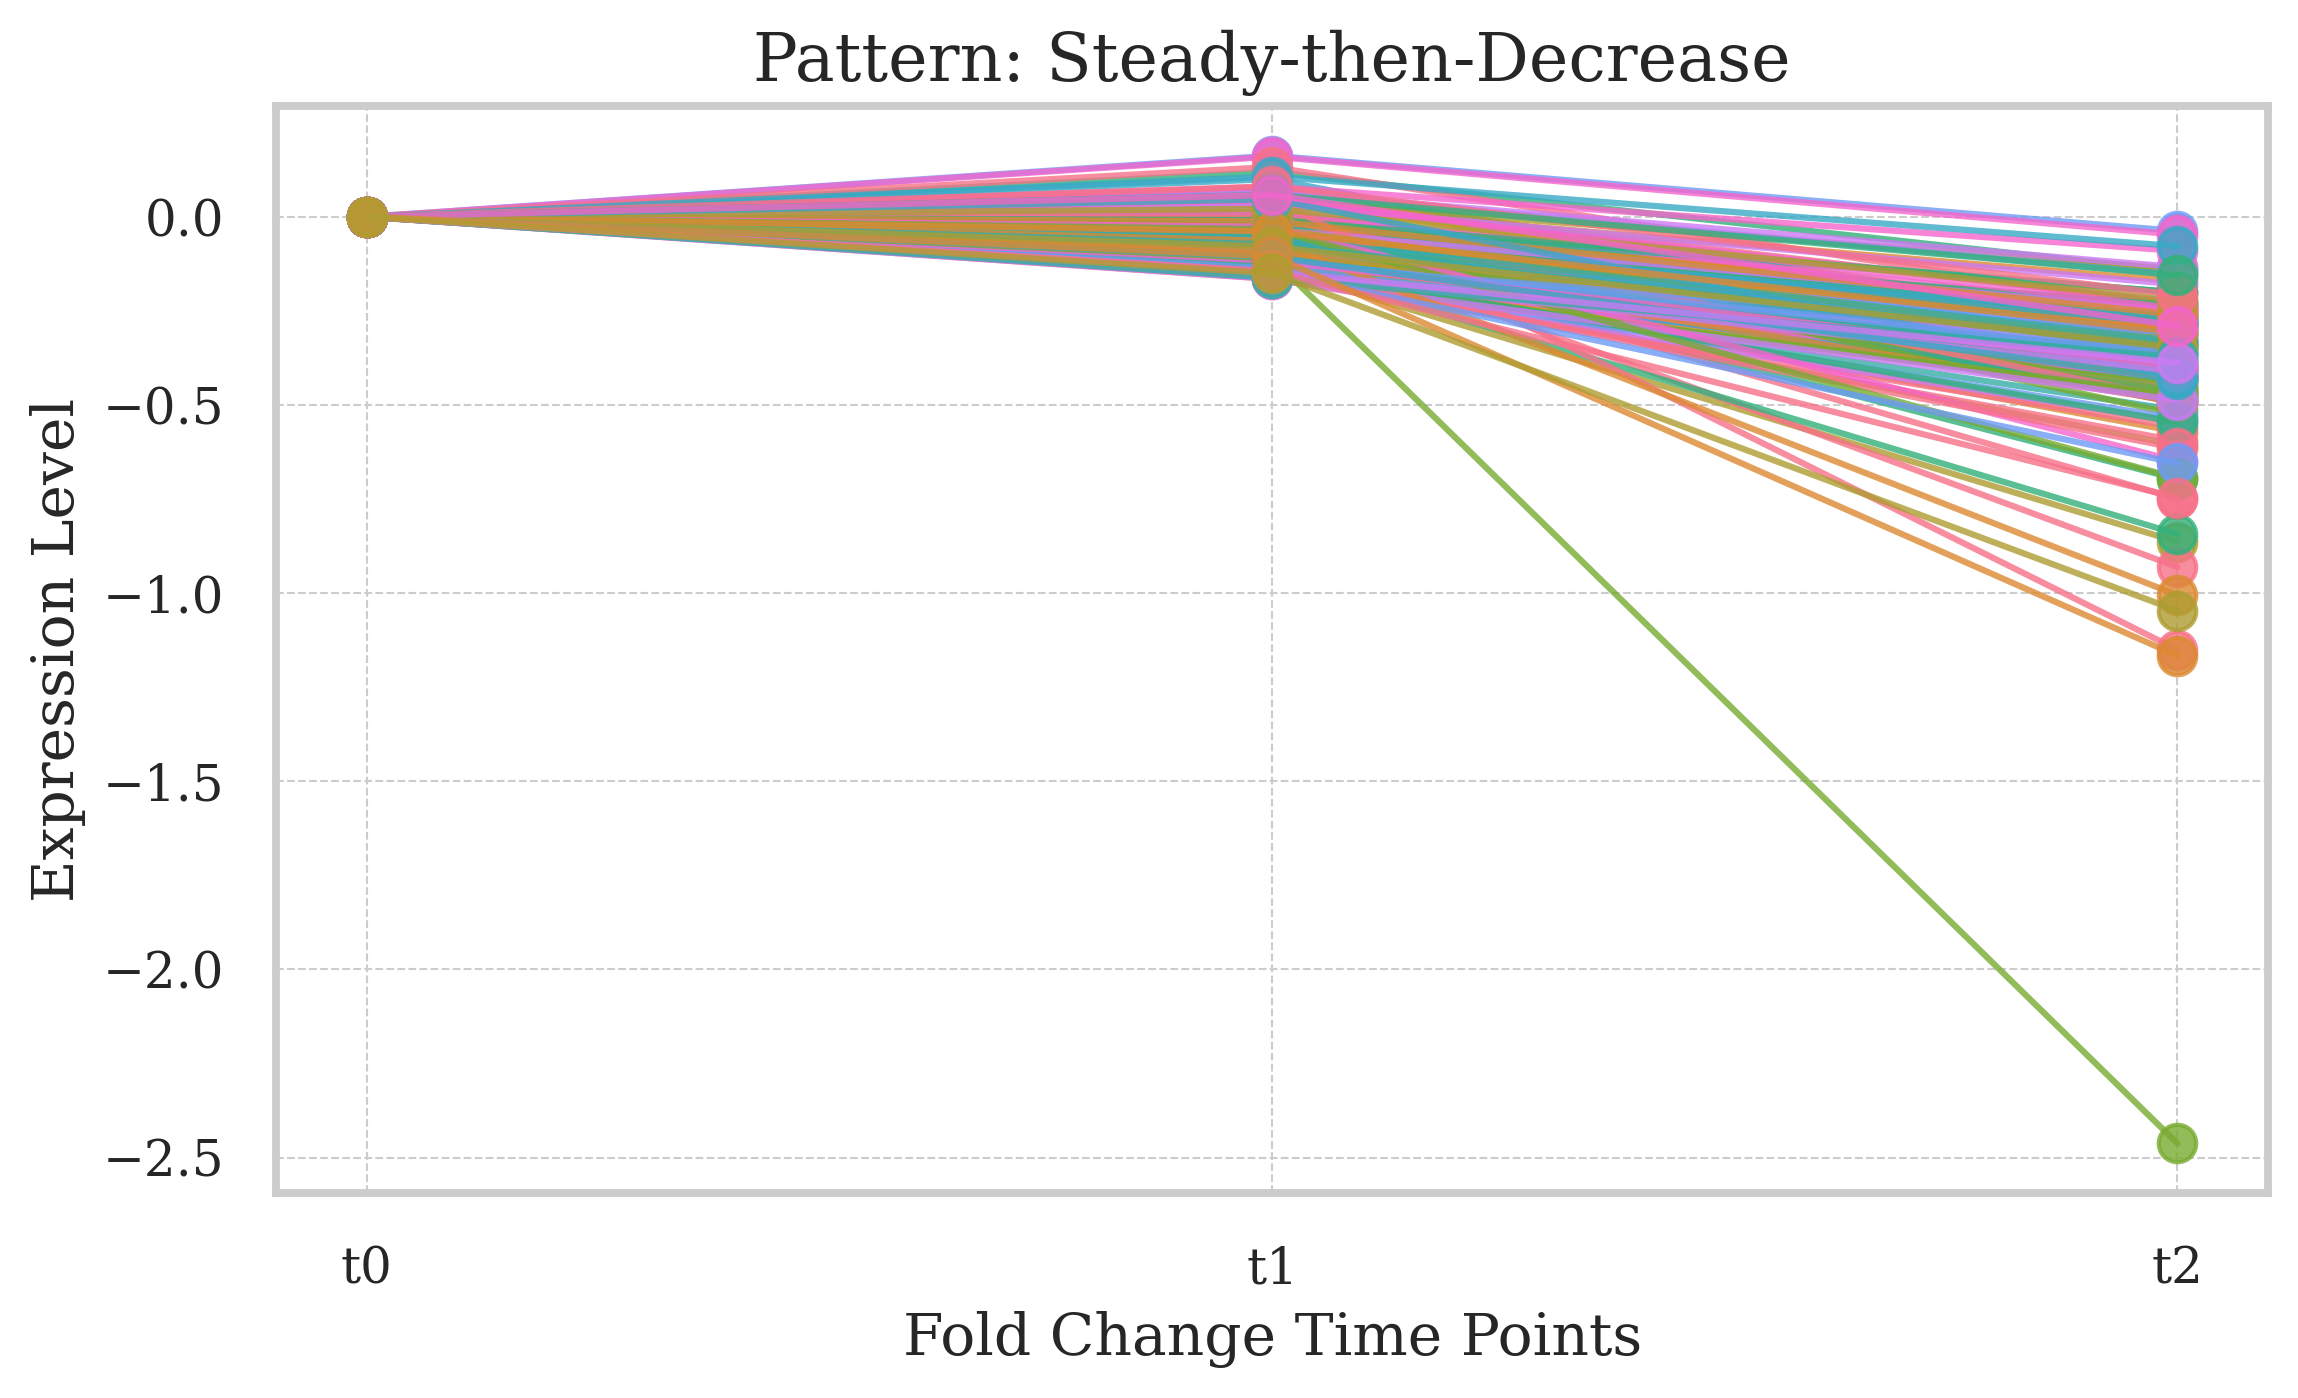

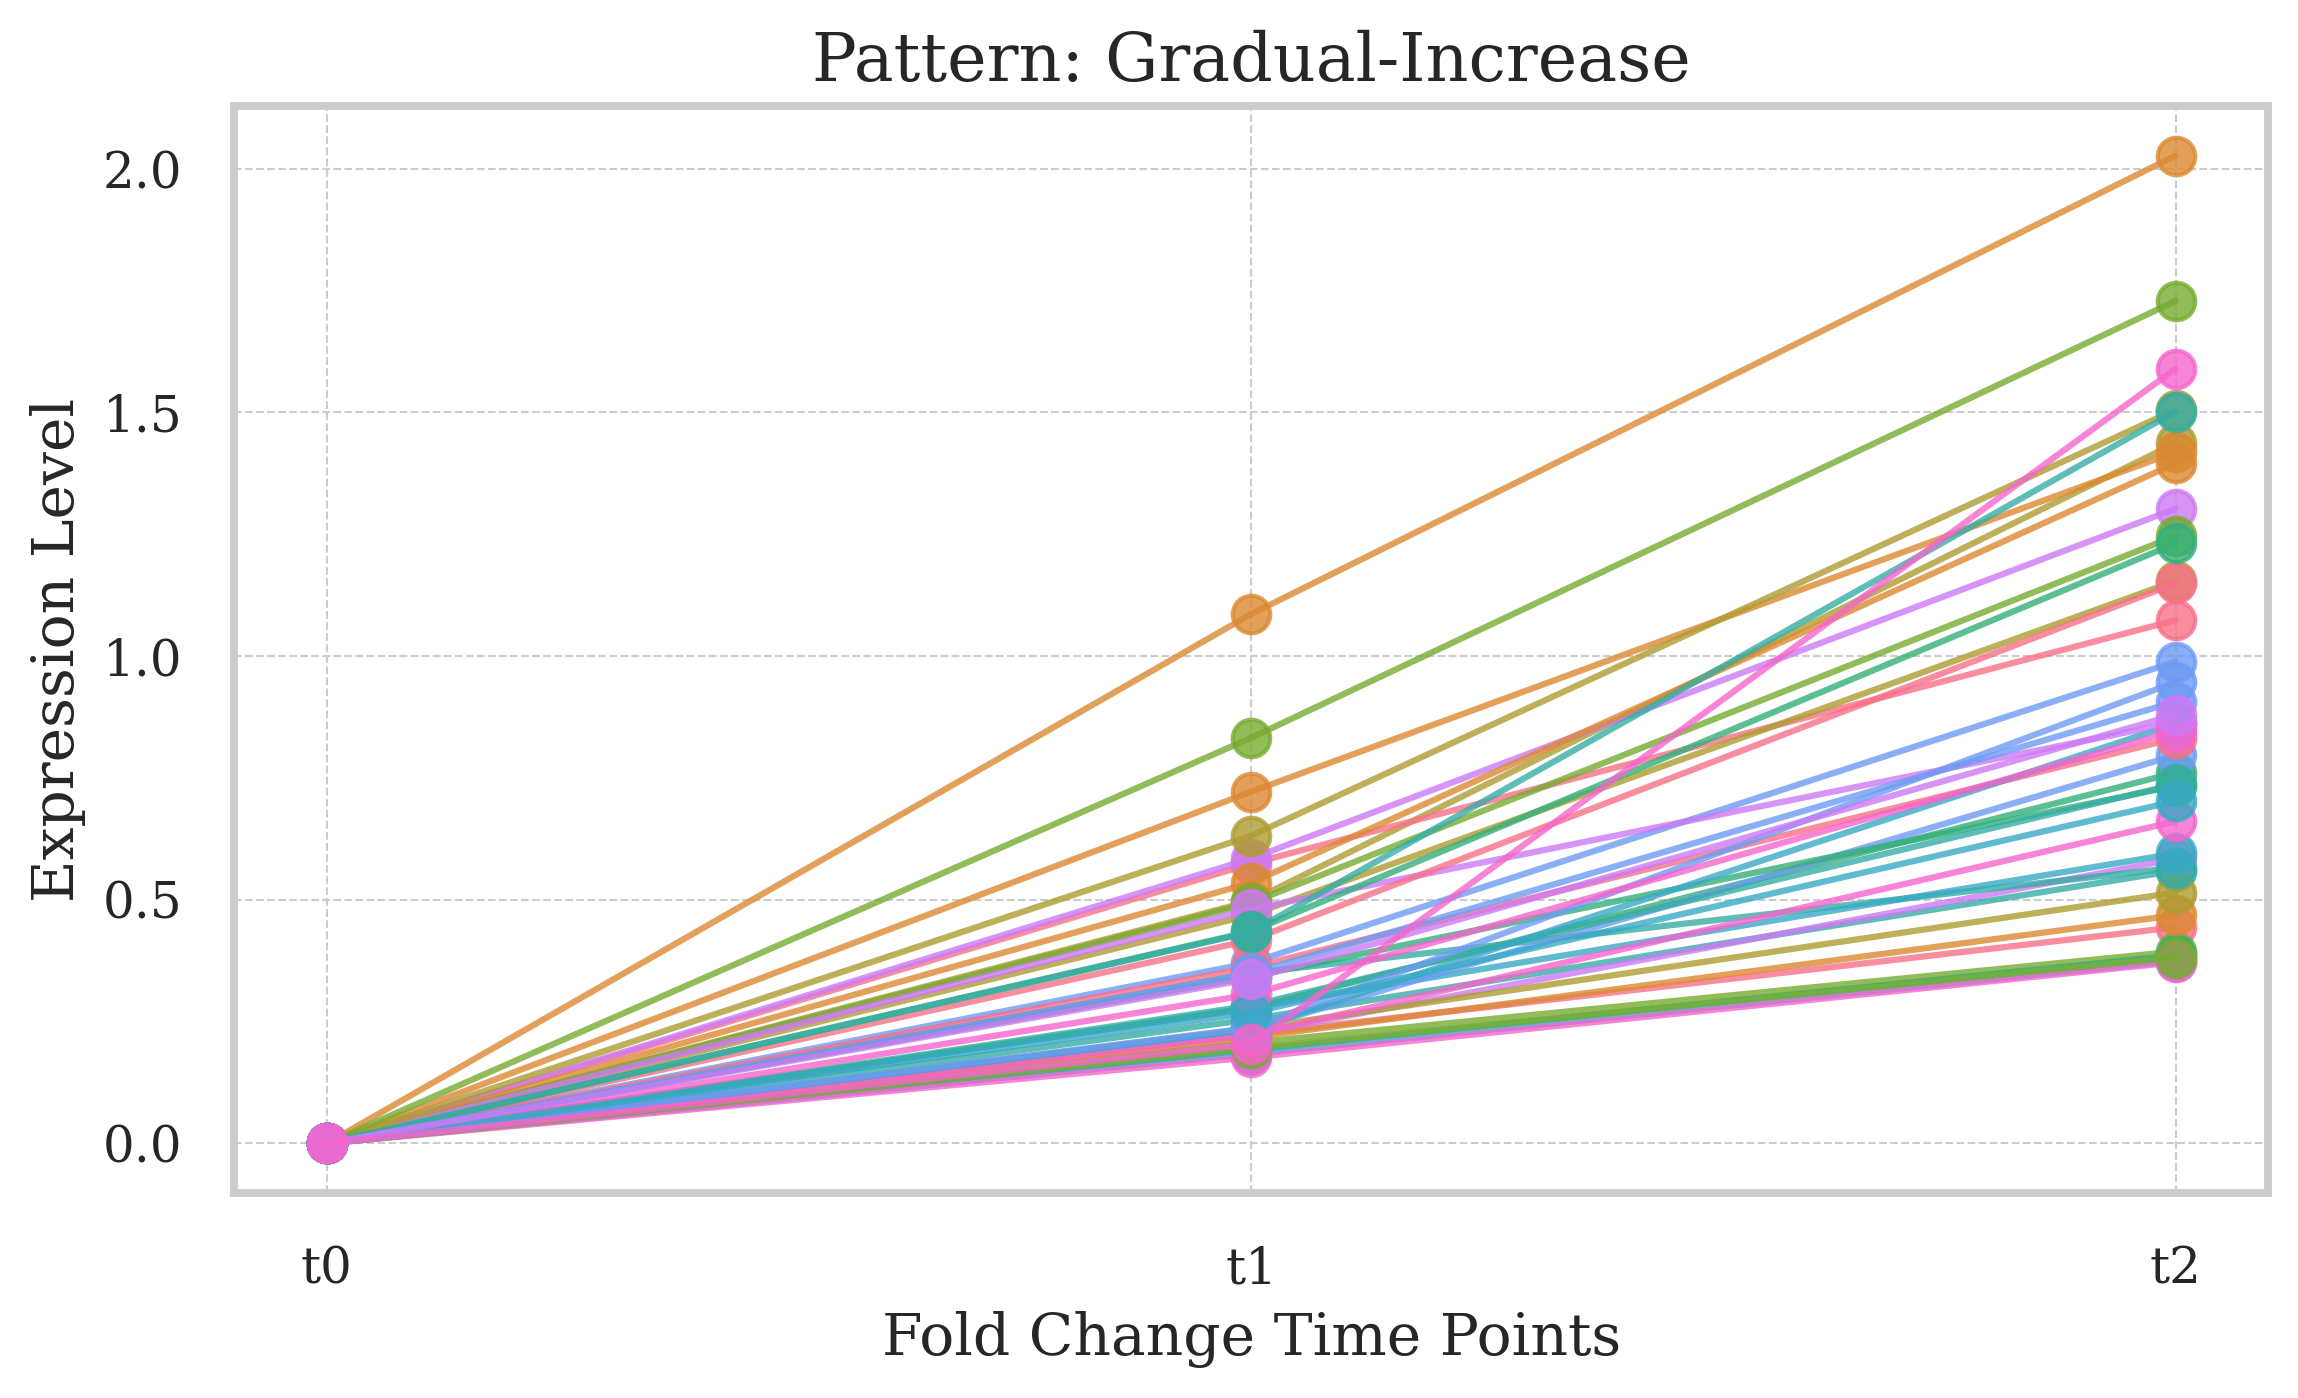

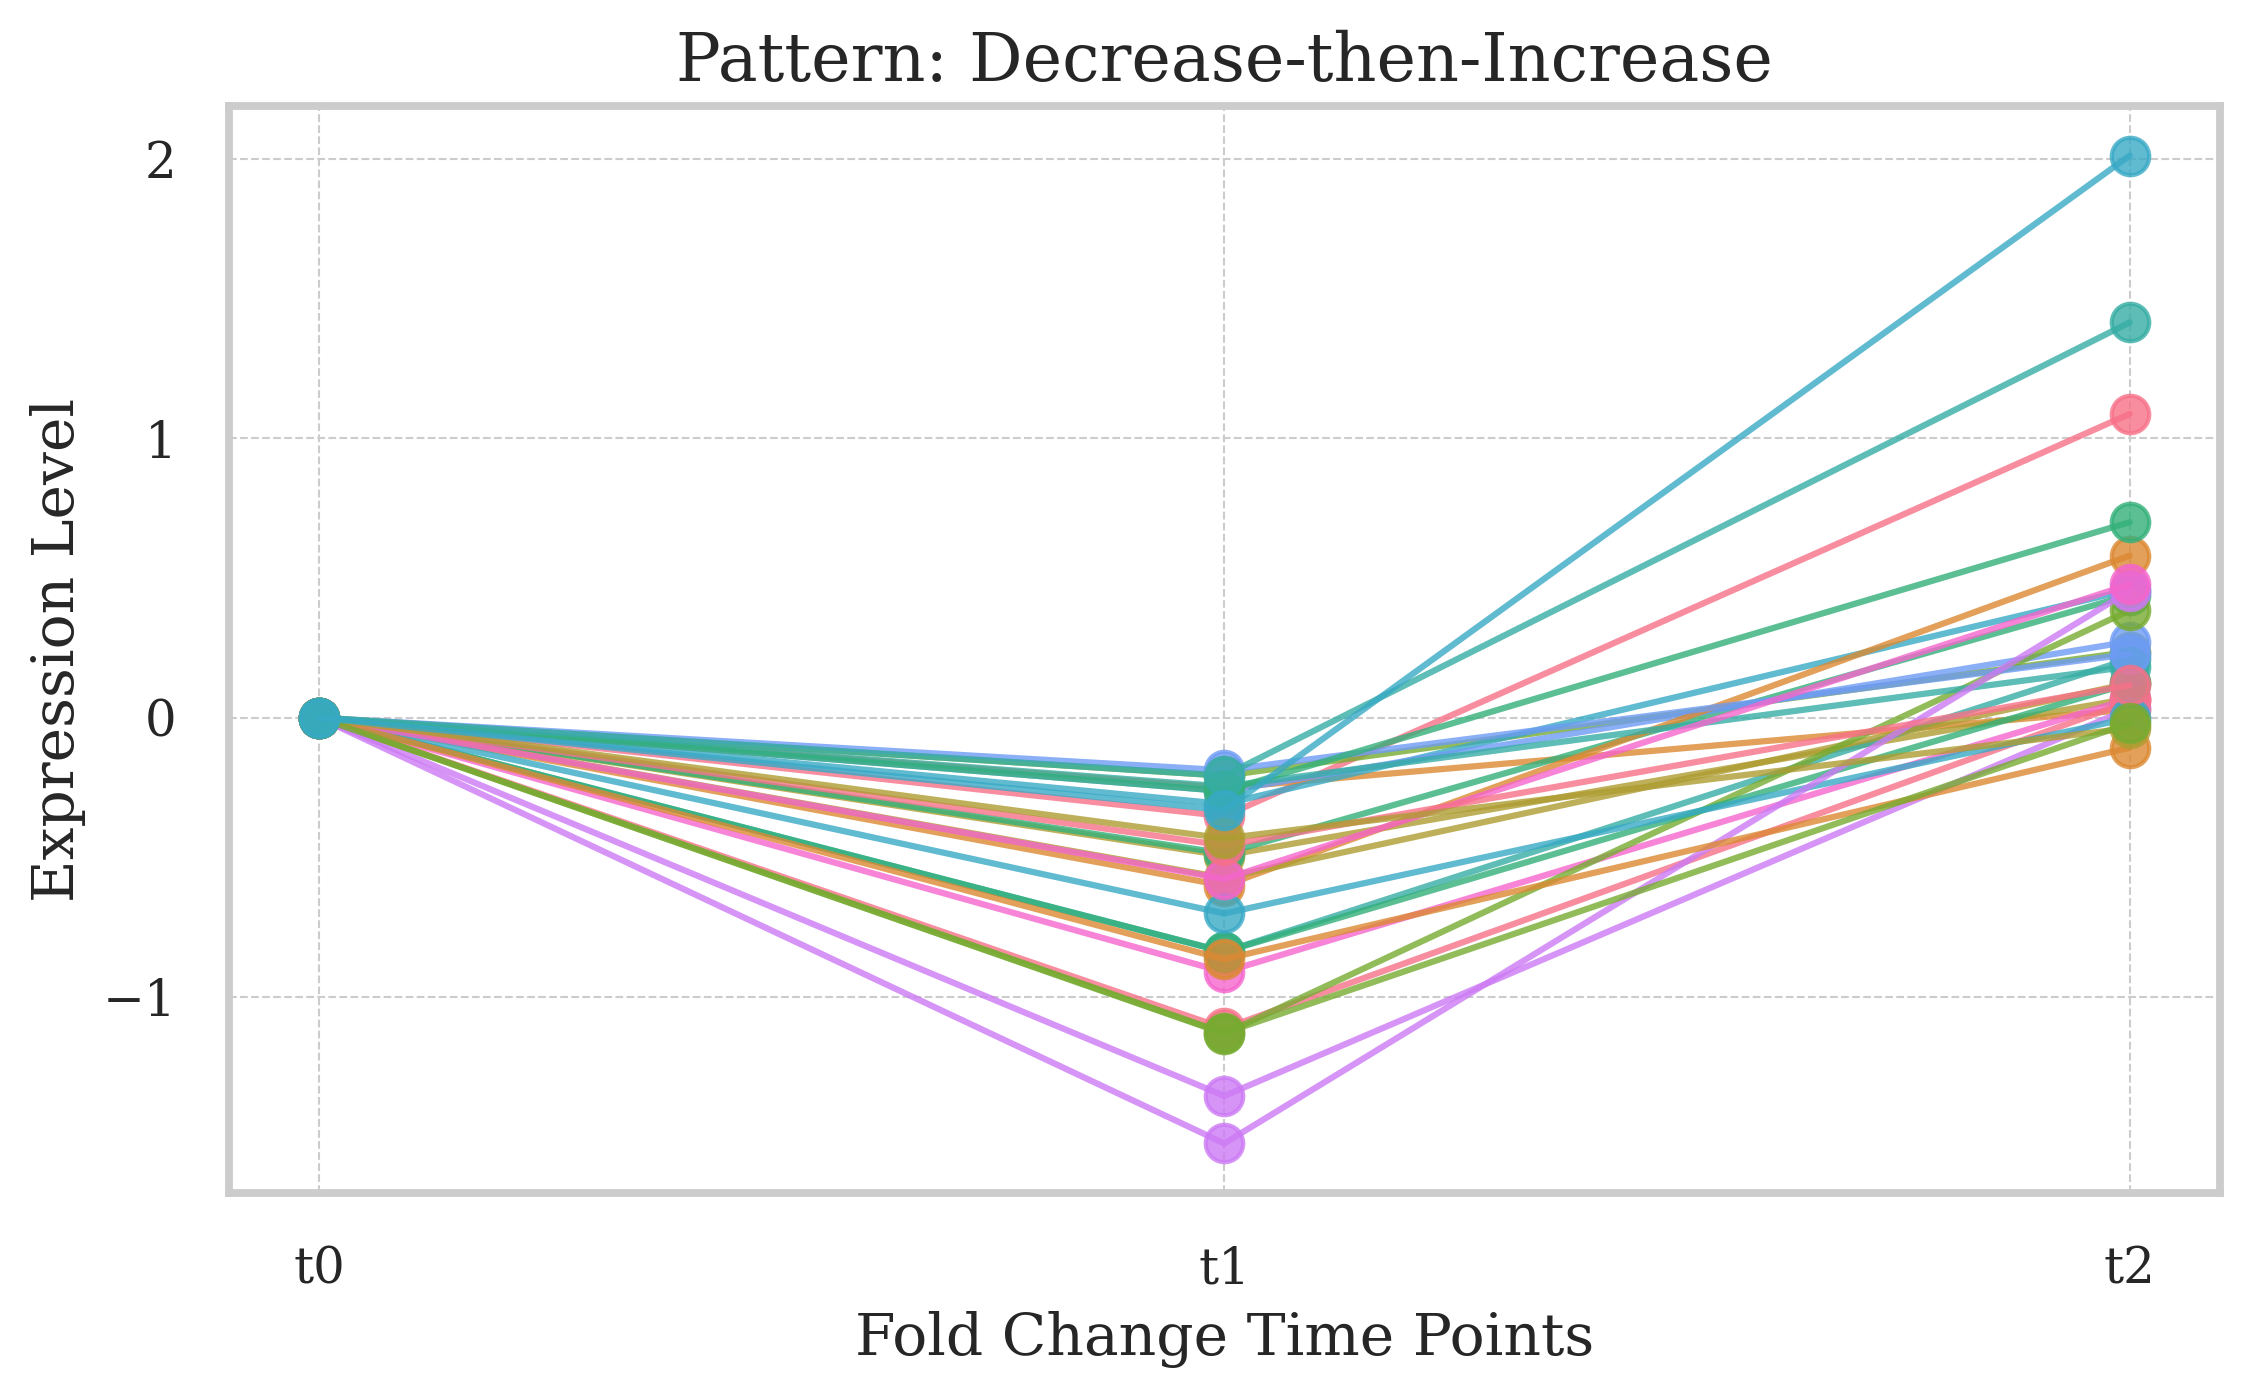

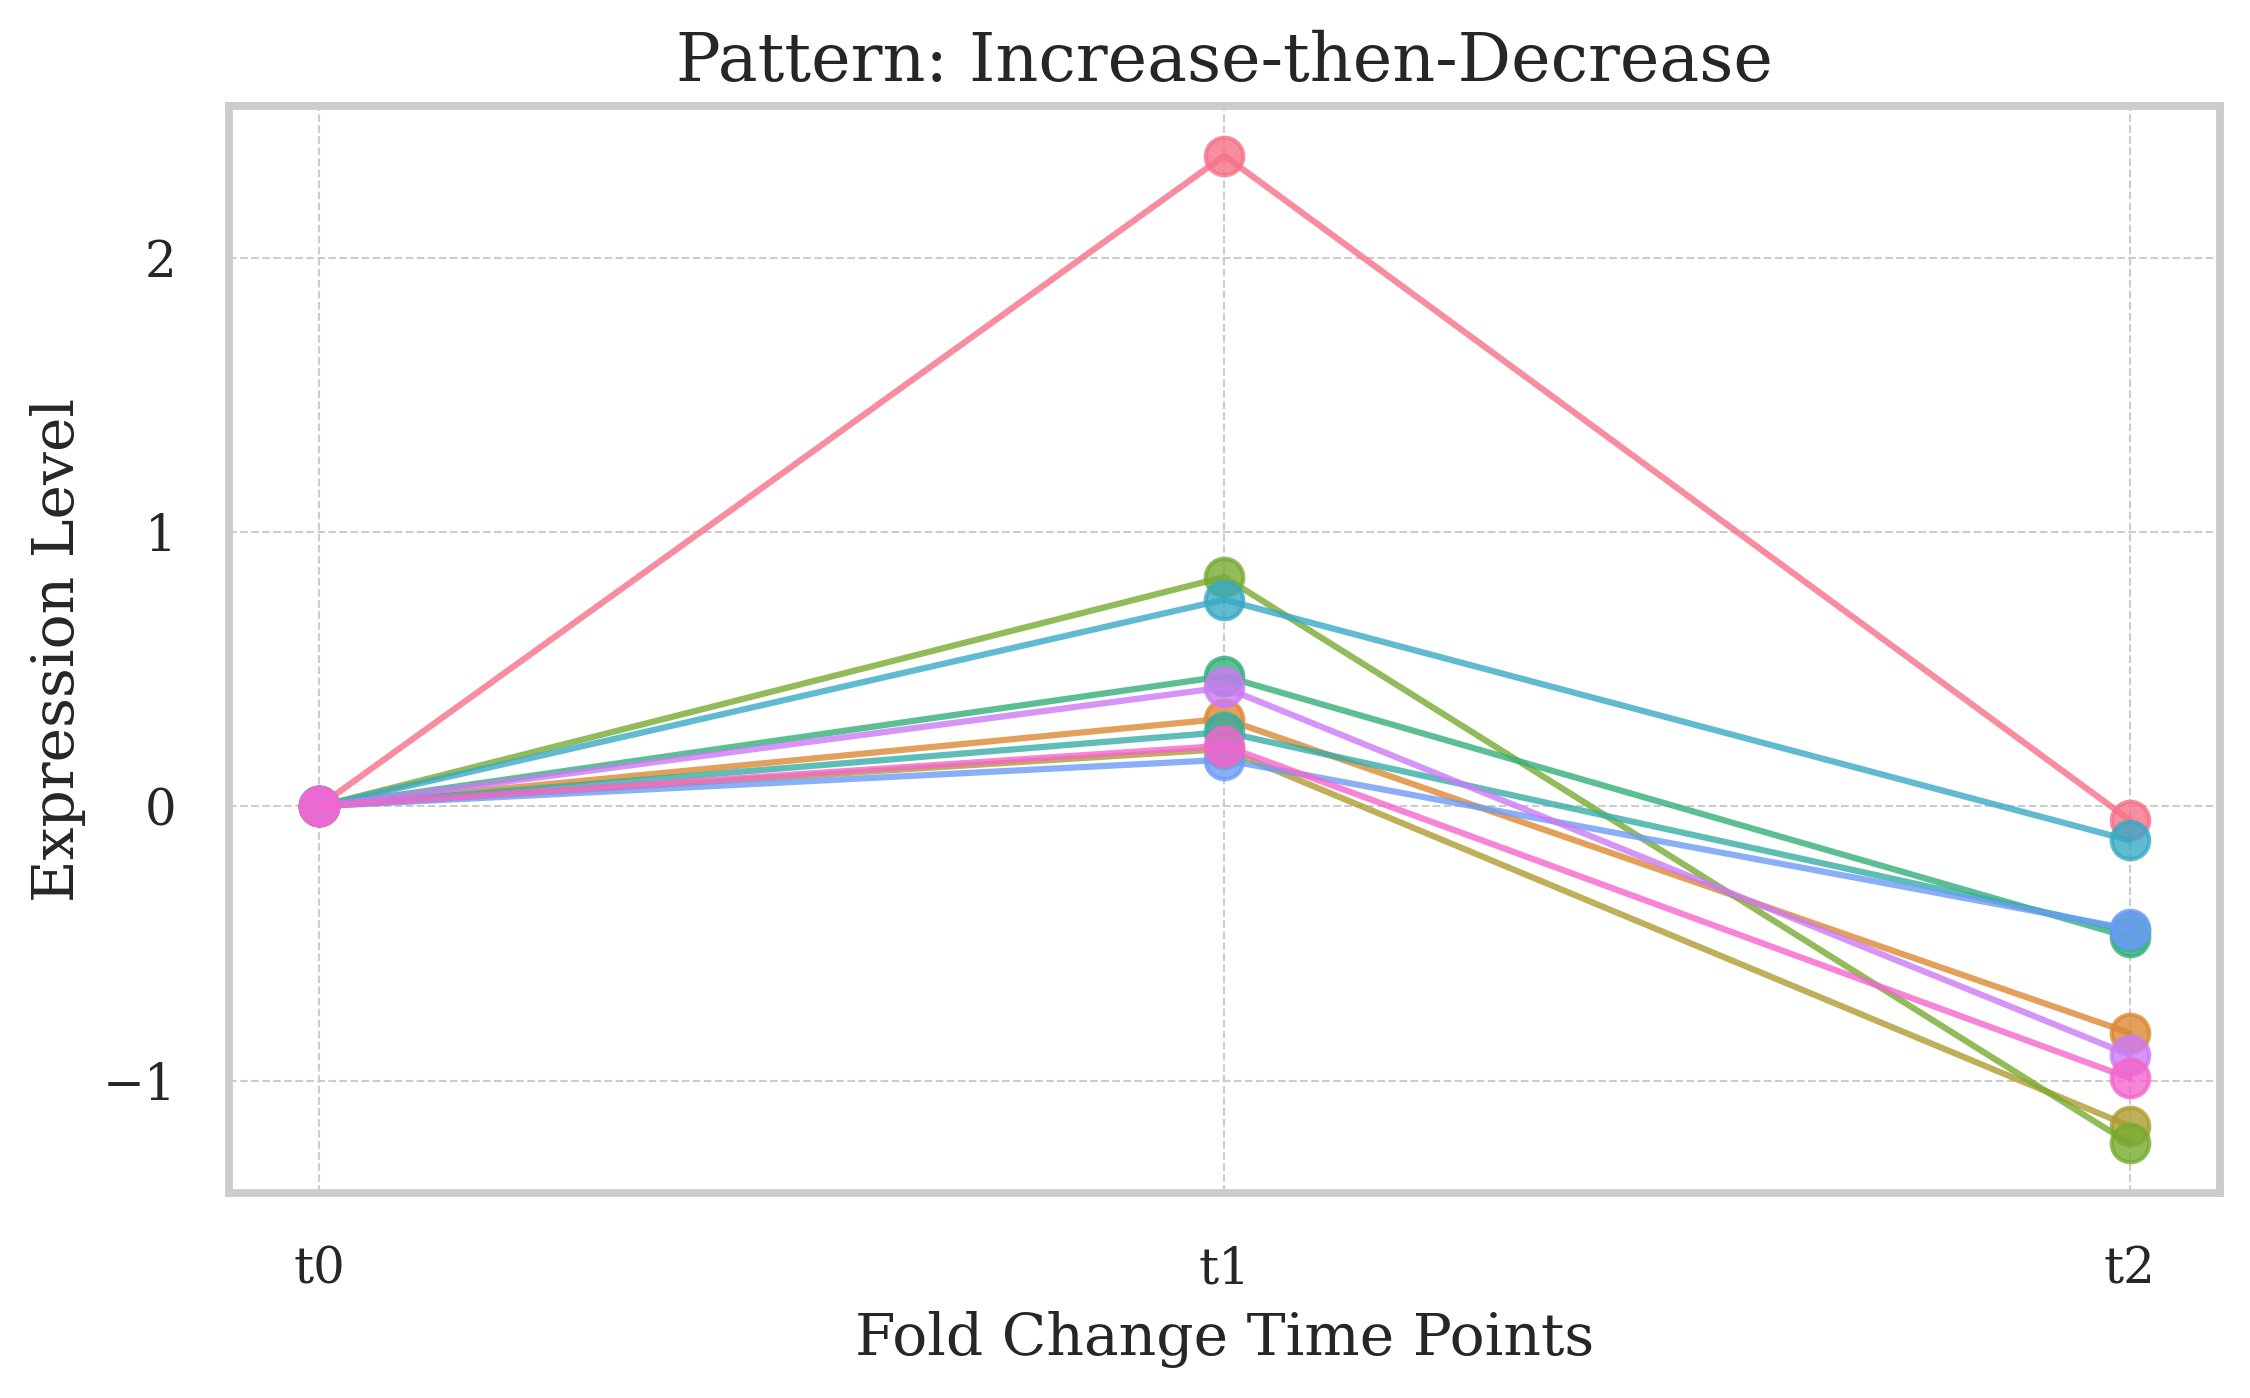

In [69]:
# all the plot without filter

for pattern in unique_patterns:
    subset = data_m[data_m['pattern'] == pattern]
    plt.figure(figsize=(8, 5))

    for i, (_, row) in enumerate(subset.iterrows()):
        color = palette[i % len(palette)]
        plt.plot(timepoints, row[timepoints], marker='o', linewidth=1.5, alpha=0.8, color=color)

    plt.title(f'Pattern: {pattern}', fontsize=16)
    plt.xlabel('Fold Change Time Points', fontsize=14)
    plt.ylabel('Expression Level', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Optional: comment this if too many lines
    #plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=8)

    plt.show()